In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals
from keras import models
from keras import optimizers
from keras import callbacks
from keras.optimizers import Adam
from keras import layers
from keras.utils.vis_utils import plot_model
import keras.backend as K

import tensorflow as tf

import numpy as np
import skimage
import cv2
import scipy.io
import pprint
import glob

import PIL as pillow
from PIL import Image

import os
from matplotlib import pyplot as plt
import matplotlib

from keras.engine.topology import Layer

from mpl_toolkits.mplot3d import Axes3D
from keras.models import load_model

import random
from sklearn.model_selection import train_test_split

# tf.enable_eager_execution()

%matplotlib inline

Using TensorFlow backend.


In [2]:
labels_model= ['auto','people','tree','beton','sign']
num_classes = len(labels_model)

IMAGE_H, IMAGE_W, IMAGE_D = 1024, 256, 80
GRID_H,  GRID_W, GRID_D = 16,8,5
BOX              = 5
CLASS            = len(labels_model)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
# ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
anchors_list = [[60,60,40],[50,40,40],[40,40,40], [20,20,40], [10,10,40],[30,30,40]]
num_boxes = len(anchors_list)

BATCH_SIZE       = 1
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


ALPHA = 0.1

In [3]:
input_image = layers.Input(shape=(IMAGE_H/2,IMAGE_W/2,IMAGE_D/2,1))
true_boxes  = layers.Input(shape=(20, 5))
def get_model():
    
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same', name = 'conv_0_1')(input_image)
    x = layers.BatchNormalization(name='norm_0_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(2,2,1))(x)
#     print(x.shape)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same',name = 'conv_1_1')(x)
    x = layers.BatchNormalization(name='norm_1_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,4,4))(x)
#     print(x.shape)
    
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same')(x)
    x = layers.BatchNormalization(name='norm_5_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,2,2))(x)
    
    x = layers.Conv3D(filters = (4+1+num_classes)*num_boxes, kernel_size=(1,1,1), strides =(1,1,1), padding = 'same', name= 'yolo')(x)
#     print(x.shape)
    output = layers.Reshape((GRID_H,GRID_W,GRID_D,num_boxes, 4+1+num_classes))(x)
    
    output = layers.Lambda(lambda args: args[0])([output, true_boxes])
    
    model = models.Model([input_image,true_boxes],output)
    return model

In [320]:
# model = Model(inputs = input,outputs = x)
# model = get_model()
# model.summary()
mypotim=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


# model_loss = mine_loss()

model.compile(loss=model_loss, optimizer=mypotim)

In [321]:
model.load_weights('weights_good_loader.h5')

In [44]:
directory_val = os.path.abspath('val_data')
pathname_val = os.listdir(directory_val)
def return_val():
    for file in pathname_val:
        matr = scipy.io.loadmat(os.path.join(directory_val,file))

        frame_data = np.zeros((40,512,128,40,1))
        targets_data = np.zeros((40,20,5))
        y_true_data = np.zeros((40,16,8,5,6,10))
        for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
        #                 true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
                    targets = targets/2
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
        #                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

                    frame_data[num_frame,...] = frame
                    targets_data[num_frame,...] = targets[0]
                    y_true_data[num_frame,...] = y_true
    return ([frame_data,targets_data], y_true_data )


In [43]:
pathname = os.path.abspath('data')
def generator_2(pathname = pathname):
    while True:
        for file in random.shuffle(glob.glob(pathname+'/*.mat')):
            matr = scipy.io.loadmat(file)
            for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                Labels = Labels/2
                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
                    true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                    yield ([frame,targets], y_true )

In [45]:
pathname = os.path.abspath('data')
dir_list = os.listdir(pathname)
full_frame_dir = []

for dir_item in dir_list:
    for num in range(40):
        full_frame_dir.append([os.path.join(pathname,dir_item), num])
#     print(os.path.join(pathname, dir_item))
# print(full_frame_dir[0])

train_list, test_list = train_test_split(full_frame_dir, train_size = 0.96)

def generator_train(train_list = train_list):
    while True:
        random.shuffle(train_list)
        for item in train_list:
            file = item[0]
            num_frame = item[1]
            matr = scipy.io.loadmat(file)
            Labels = np.array(matr["Labels"][num_frame])
            Labels = Labels/2
            object_mask = Labels[:,0]
            if object_mask.shape[0] != 0:
                true_boxes = Labels[:,:]
                targets = np.expand_dims(Labels,0)
                targets = abs(targets)
                frame = matr["Matr"][num_frame]
                frame = frame[::2,::2,::2]
                frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                yield ([frame,targets], y_true )
    
def return_test():
    counter = 0 
    for item in test_list:
        
        file = item[0]
        num_frame = item[1]
        matr = scipy.io.loadmat(file)

        frame_data = np.zeros((len(test_list),512,128,40,1))
        targets_data = np.zeros((len(test_list),20,5))
        y_true_data = np.zeros((len(test_list),16,8,5,6,10))
        Labels = np.array(matr["Labels"][num_frame])
        object_mask = Labels[:,0]
        if object_mask.shape[0] != 0:
#                 true_boxes = Labels[:,:]
            targets = np.expand_dims(Labels,0)
            targets = targets/2
            targets = abs(targets)
            frame = matr["Matr"][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
            y_true = preprocess_true_boxes(targets)
#                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

            frame_data[counter,...] = frame
            targets_data[counter,...] = targets[0]
            y_true_data[counter,...] = y_true
            counter += 1
    return ([frame_data,targets_data], y_true_data )

In [13]:
counter = 0
val_loss_arr  = []
loss_arr = []
while True:
    print(counter)
    counter += 1
    H = model.fit_generator(generator_2(),validation_data=return_val(), steps_per_epoch= 40, epochs = 2)
    val_loss_arr.append(H.history['val_loss'])
    loss_arr.append(H.history['loss'])
#     plt.figure()
#     plt.plot(val_loss_arr[-1])
#     plt.plot(loss_arr[-1])
#     plt.show()


Epoch 1/10
60/60 [==============================] - 138s 2s/step - loss: 53.7126 - val_loss: 124.0207
Epoch 2/10
60/60 [==============================] - 130s 2s/step - loss: 40.1236 - val_loss: 107.7642
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 40.0587 - val_loss: 110.1712
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 44.2805 - val_loss: 117.8657
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 40.5131 - val_loss: 112.6584
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 36.0515 - val_loss: 106.9817
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 39.6552 - val_loss: 117.1509
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 29.1372 - val_loss: 120.5694
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 36.0923 - val_loss: 106.8003
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 34.2449 

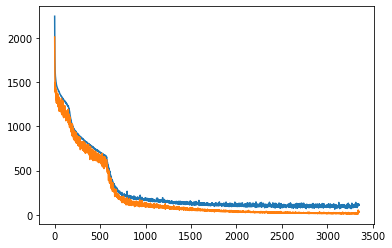

Epoch 1/10
60/60 [==============================] - 138s 2s/step - loss: 28.9444 - val_loss: 109.3695
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 34.8298 - val_loss: 112.9567
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 28.5348 - val_loss: 117.0516
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 26.4819 - val_loss: 104.8282
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 28.8472 - val_loss: 117.1076
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 24.7818 - val_loss: 97.7145
Epoch 7/10
60/60 [==============================] - 129s 2s/step - loss: 29.5213 - val_loss: 107.5460
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 28.6307 - val_loss: 97.3045
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 29.1247 - val_loss: 102.0231
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 24.9775 - 

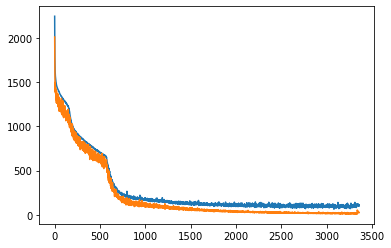

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 25.6522 - val_loss: 96.3120
Epoch 2/10
60/60 [==============================] - 130s 2s/step - loss: 26.9811 - val_loss: 120.0742
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 22.6929 - val_loss: 94.9753
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 24.0338 - val_loss: 100.0551
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 23.1204 - val_loss: 99.1311
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 21.9791 - val_loss: 105.2094
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 22.9041 - val_loss: 100.3311
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 19.2481 - val_loss: 82.2966
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 24.7479 - val_loss: 103.2680
Epoch 10/10
60/60 [==============================] - 132s 2s/step - loss: 23.7425 - va

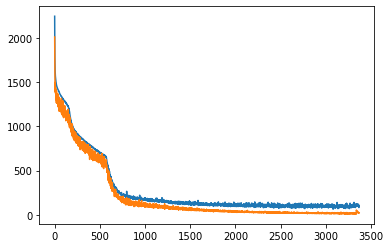

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 22.1304 - val_loss: 114.3650
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 21.0472 - val_loss: 100.4725
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 21.6232 - val_loss: 112.5173
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 23.1803 - val_loss: 87.5824
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 16.3847 - val_loss: 91.6903
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 25.7402 - val_loss: 98.6809
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 19.1272 - val_loss: 111.4361
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 23.8390 - val_loss: 97.5803
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 14.6377 - val_loss: 119.2009
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 18.0952 - va

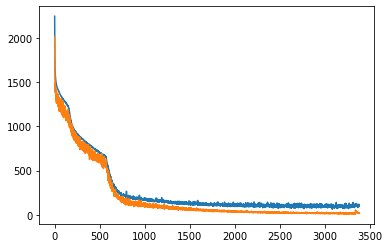

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 16.1727 - val_loss: 102.1578
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 14.2870 - val_loss: 109.9838
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 13.5989 - val_loss: 116.6038
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 16.3409 - val_loss: 90.4731
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 14.9230 - val_loss: 103.5566
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 19.1917 - val_loss: 77.8988
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 18.9152 - val_loss: 97.2076
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 17.2109 - val_loss: 101.3563
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 16.2735 - val_loss: 128.0238
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 16.0529 - v

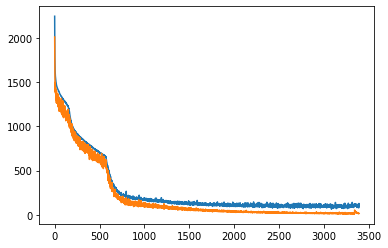

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 15.8453 - val_loss: 106.0919
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 20.4519 - val_loss: 107.8425
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 11.6424 - val_loss: 128.9476
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 15.9775 - val_loss: 109.9169
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 13.6195 - val_loss: 104.8548
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 14.9297 - val_loss: 105.7986
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 13.9207 - val_loss: 107.5392
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 12.0025 - val_loss: 85.6709
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 14.8216 - val_loss: 102.8830
Epoch 10/10
60/60 [==============================] - 129s 2s/step - loss: 14.8660 -

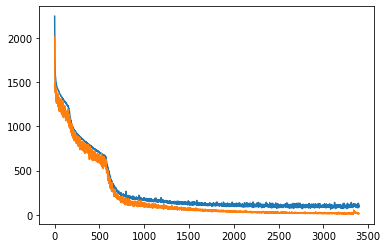

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 14.0070 - val_loss: 99.8681
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 12.7581 - val_loss: 108.6556
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 13.2897 - val_loss: 84.4940
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 12.7657 - val_loss: 92.2387
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 13.3636 - val_loss: 90.4367
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 21.8486 - val_loss: 100.8488
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 16.7224 - val_loss: 89.4654
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 14.3829 - val_loss: 107.8804
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 16.2945 - val_loss: 111.2234
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 16.4052 - val

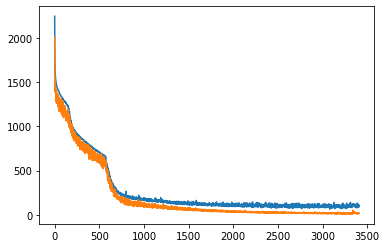

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 17.4771 - val_loss: 95.4824
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 13.2232 - val_loss: 112.9739
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 15.7787 - val_loss: 102.3872
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 12.8185 - val_loss: 100.6679
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 15.6344 - val_loss: 93.9743
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 14.2299 - val_loss: 85.9645
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 25.1550 - val_loss: 100.2279
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 27.7456 - val_loss: 122.2101
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 20.1058 - val_loss: 99.7583
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 19.4429 - va

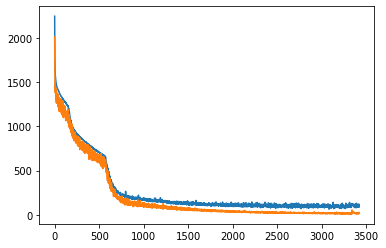

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 17.3506 - val_loss: 79.8406
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 13.7005 - val_loss: 74.8489
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 21.6801 - val_loss: 89.1484
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 25.7369 - val_loss: 102.0676
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 19.9391 - val_loss: 99.1354
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 19.5955 - val_loss: 128.7392
Epoch 7/10
60/60 [==============================] - 129s 2s/step - loss: 16.3150 - val_loss: 100.9900
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 13.3302 - val_loss: 110.5876
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 11.9601 - val_loss: 99.6122
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.8937 - val

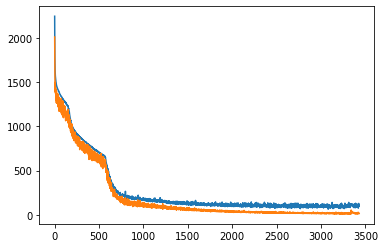

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 15.9779 - val_loss: 119.3498
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 11.9586 - val_loss: 98.3295
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 13.1459 - val_loss: 97.0474
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 12.1783 - val_loss: 124.2786
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 16.8282 - val_loss: 105.2847
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 15.8613 - val_loss: 82.4613
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 17.2105 - val_loss: 90.0046
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 13.3234 - val_loss: 77.6477
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 14.3165 - val_loss: 97.4159
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 15.2390 - val_

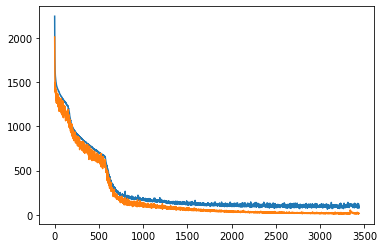

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 12.4314 - val_loss: 79.6210
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 14.8086 - val_loss: 84.4422
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 16.6819 - val_loss: 95.8064
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 17.0611 - val_loss: 88.3141
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 12.1562 - val_loss: 103.9030
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 12.4972 - val_loss: 90.2876
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 11.9443 - val_loss: 95.9835
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 12.9705 - val_loss: 102.7277
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 14.6235 - val_loss: 106.6365
Epoch 10/10
60/60 [==============================] - 132s 2s/step - loss: 11.3107 - val_

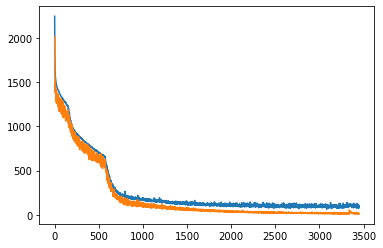

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 12.5131 - val_loss: 88.1469
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 11.7010 - val_loss: 81.6582
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 14.5960 - val_loss: 82.9051
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 16.2499 - val_loss: 67.4056
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 12.5268 - val_loss: 74.2775
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 14.1961 - val_loss: 64.1379
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 10.9295 - val_loss: 79.6134
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 11.1473 - val_loss: 97.8069
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 14.9438 - val_loss: 131.5386
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.5943 - val_lo

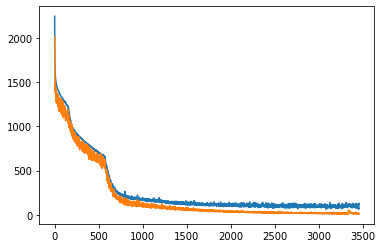

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 18.7080 - val_loss: 116.7983
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 22.4815 - val_loss: 99.5190
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 16.3111 - val_loss: 103.9628
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 15.6063 - val_loss: 102.2605
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 14.5655 - val_loss: 98.1797
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 18.0103 - val_loss: 100.0320
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 14.4426 - val_loss: 77.4400
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 12.4822 - val_loss: 84.2769
Epoch 9/10
60/60 [==============================] - 129s 2s/step - loss: 9.5780 - val_loss: 74.4950
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 14.2306 - val_

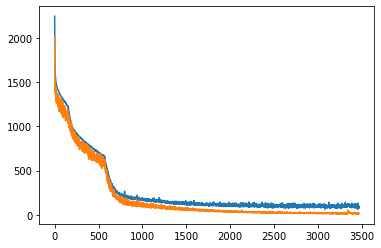

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 11.3066 - val_loss: 88.2570
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 11.1893 - val_loss: 89.2080
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 17.0629 - val_loss: 97.5941
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 13.3167 - val_loss: 105.3124
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 11.1651 - val_loss: 104.3817
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 12.8524 - val_loss: 102.3074
Epoch 7/10
60/60 [==============================] - 129s 2s/step - loss: 13.0753 - val_loss: 93.1708
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 11.6545 - val_loss: 112.8485
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 15.3855 - val_loss: 125.0295
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 17.8542 - va

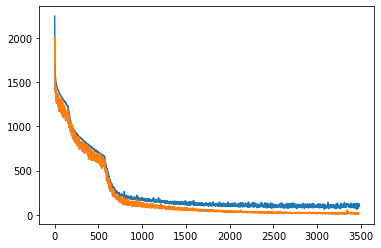

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 16.1836 - val_loss: 102.5403
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 10.6868 - val_loss: 130.5895
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 12.9788 - val_loss: 104.4124
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 13.0290 - val_loss: 109.3296
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 12.9299 - val_loss: 84.1265
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 12.7535 - val_loss: 89.1264
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 14.3145 - val_loss: 79.8218
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 13.3758 - val_loss: 94.2365
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 11.0642 - val_loss: 79.3789
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.3243 - val

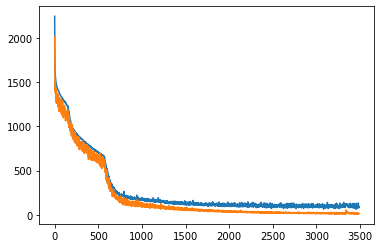

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 12.1496 - val_loss: 104.2619
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 15.3406 - val_loss: 86.4944
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 16.6020 - val_loss: 111.8699
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 18.4806 - val_loss: 110.8228
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 14.5949 - val_loss: 94.4770
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 13.6450 - val_loss: 105.1839
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 12.5579 - val_loss: 107.4737
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 12.8916 - val_loss: 101.1213
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 10.9022 - val_loss: 100.7667
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 13.0882 - 

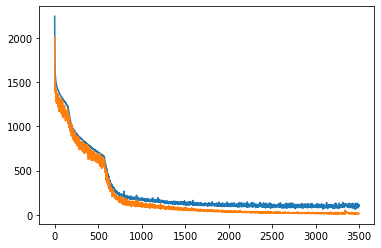

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 15.3594 - val_loss: 111.4633
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 14.3938 - val_loss: 97.1746
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 12.7722 - val_loss: 118.5137
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 12.6847 - val_loss: 124.1351
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 12.2882 - val_loss: 134.2041
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 20.0623 - val_loss: 90.1275
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 18.0499 - val_loss: 88.3997
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 15.0761 - val_loss: 79.4480
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 12.1834 - val_loss: 94.8709
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 13.3010 - val

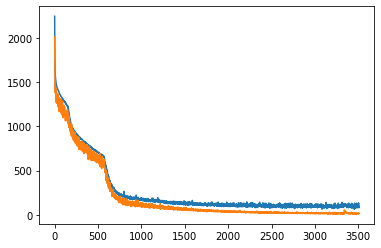

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 12.5053 - val_loss: 98.8947
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 10.8302 - val_loss: 108.4416
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 11.3714 - val_loss: 81.7500
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 18.0346 - val_loss: 93.4316
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 13.0328 - val_loss: 96.3730
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 10.9143 - val_loss: 109.3588
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 13.7593 - val_loss: 97.9643
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 13.2075 - val_loss: 94.5634
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 10.9931 - val_loss: 89.2390
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 10.8276 - val_l

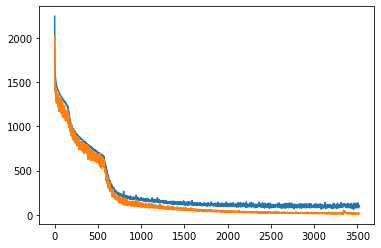

Epoch 1/10
60/60 [==============================] - 141s 2s/step - loss: 18.0017 - val_loss: 96.0490
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 14.2634 - val_loss: 96.4730
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 12.6153 - val_loss: 83.7801
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 9.8663 - val_loss: 83.1217
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 19.5087 - val_loss: 70.9450
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 15.2290 - val_loss: 103.4569
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 14.2182 - val_loss: 80.4943
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 19.3799 - val_loss: 96.8322
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 16.5420 - val_loss: 83.8252
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.0302 - val_los

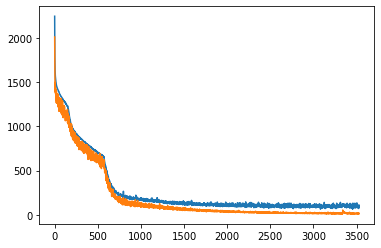

Epoch 1/10
60/60 [==============================] - 141s 2s/step - loss: 11.2572 - val_loss: 80.8635
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 12.0044 - val_loss: 78.6069
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 13.1420 - val_loss: 97.2121
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 12.3628 - val_loss: 87.9714
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 16.1700 - val_loss: 74.6000
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 13.0402 - val_loss: 106.6068
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 13.6898 - val_loss: 90.9063
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 15.7052 - val_loss: 87.6411
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 12.8150 - val_loss: 97.5025
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 13.2022 - val_lo

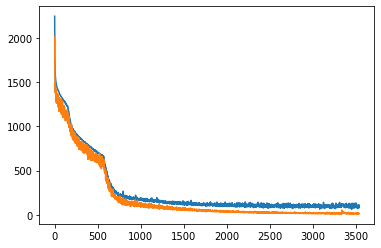

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 15.7597 - val_loss: 113.8501
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 11.2562 - val_loss: 109.1128
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 11.5557 - val_loss: 96.6015
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 13.9259 - val_loss: 89.2397
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 9.7263 - val_loss: 85.7091
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 10.9735 - val_loss: 87.7898
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 12.8065 - val_loss: 103.5595
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 11.7001 - val_loss: 96.6323
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 11.5045 - val_loss: 91.5873
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 11.5321 - val_l

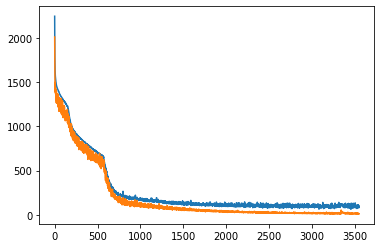

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 14.5739 - val_loss: 81.6494
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 19.4868 - val_loss: 109.0672
Epoch 3/10
60/60 [==============================] - 132s 2s/step - loss: 18.3963 - val_loss: 111.7250
Epoch 4/10
60/60 [==============================] - 132s 2s/step - loss: 11.8419 - val_loss: 91.8048
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 16.3174 - val_loss: 98.2460
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 11.7931 - val_loss: 107.8859
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 14.8018 - val_loss: 105.3657
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 12.0669 - val_loss: 93.4538
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 14.5848 - val_loss: 87.1548
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 12.5315 - val

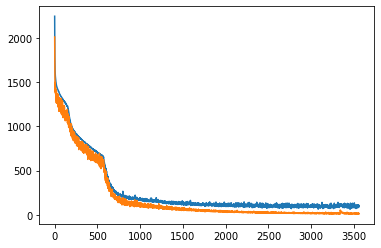

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 10.6655 - val_loss: 113.6181
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 10.8167 - val_loss: 90.0105
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 13.1439 - val_loss: 95.0445
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 12.9502 - val_loss: 91.9149
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 10.9470 - val_loss: 103.2483
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 12.5084 - val_loss: 107.5018
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 11.3495 - val_loss: 114.3808
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 16.5544 - val_loss: 77.2829
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 14.3400 - val_loss: 106.8586
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 13.9082 - va

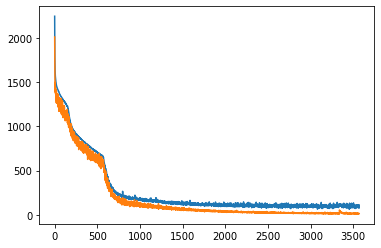

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 10.2071 - val_loss: 113.0779
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 12.0867 - val_loss: 94.2829
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 12.3009 - val_loss: 114.2433
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 11.6283 - val_loss: 109.6218
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 16.9613 - val_loss: 101.4406
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 11.3765 - val_loss: 82.4803
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 14.5366 - val_loss: 110.0609
Epoch 8/10
60/60 [==============================] - 132s 2s/step - loss: 12.7058 - val_loss: 91.5535
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 14.0998 - val_loss: 76.2616
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 19.6222 - va

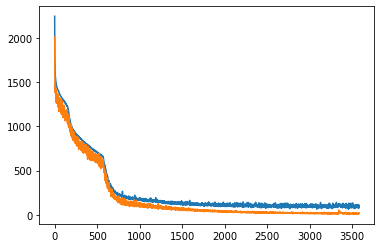

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 15.0061 - val_loss: 93.6942
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 11.8861 - val_loss: 84.4618
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 11.5158 - val_loss: 92.0822
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 10.6047 - val_loss: 85.8930
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 9.9509 - val_loss: 84.7352
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 10.5391 - val_loss: 96.7186
Epoch 7/10
60/60 [==============================] - 132s 2s/step - loss: 10.0178 - val_loss: 85.5892
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 11.3957 - val_loss: 89.0218
Epoch 9/10
60/60 [==============================] - 132s 2s/step - loss: 16.7942 - val_loss: 67.9795
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 9.8635 - val_loss:

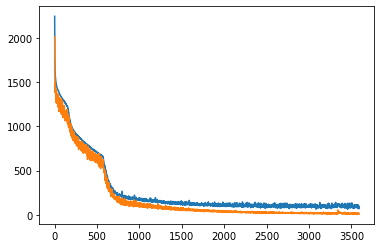

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 12.2649 - val_loss: 89.7213
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 11.1283 - val_loss: 102.9618
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 13.4657 - val_loss: 86.5682
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 10.6665 - val_loss: 86.0342
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 9.4440 - val_loss: 83.7424
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 9.8314 - val_loss: 104.1170
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 10.8150 - val_loss: 105.7832
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 12.3312 - val_loss: 93.5580
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 15.0009 - val_loss: 103.4265
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 11.8676 - val_l

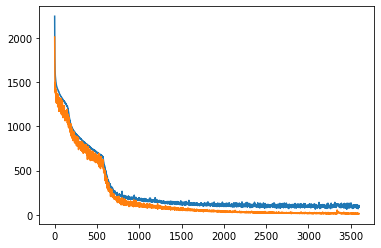

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 10.7696 - val_loss: 89.2307
Epoch 2/10
60/60 [==============================] - 133s 2s/step - loss: 13.6917 - val_loss: 77.8370
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 11.3230 - val_loss: 88.3523
Epoch 4/10
60/60 [==============================] - 132s 2s/step - loss: 11.5193 - val_loss: 84.1269
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 11.5318 - val_loss: 95.6803
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 13.7953 - val_loss: 96.9038
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 16.9379 - val_loss: 78.4352
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 14.9128 - val_loss: 80.8884
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 12.0988 - val_loss: 97.9420
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 16.0219 - val_los

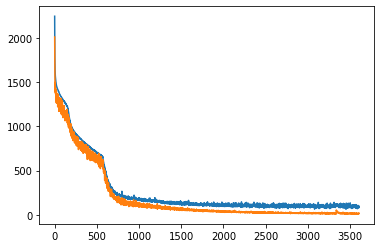

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 13.6451 - val_loss: 88.4970
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 13.3589 - val_loss: 91.2458
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 12.8656 - val_loss: 80.6713
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 13.0867 - val_loss: 107.6348
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 10.4417 - val_loss: 99.8897
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 12.5434 - val_loss: 95.2200
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 11.7181 - val_loss: 119.8889
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 15.3366 - val_loss: 107.3689
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 10.3067 - val_loss: 83.4469
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.2984 - val_

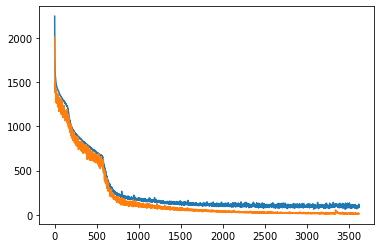

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 11.3429 - val_loss: 88.4467
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 10.1354 - val_loss: 91.9232
Epoch 3/10
60/60 [==============================] - 132s 2s/step - loss: 10.8586 - val_loss: 78.7664
Epoch 4/10
60/60 [==============================] - 132s 2s/step - loss: 12.3640 - val_loss: 87.4987
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 11.9143 - val_loss: 92.5269
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 10.7386 - val_loss: 97.3168
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 13.7231 - val_loss: 96.7125
Epoch 8/10
60/60 [==============================] - 132s 2s/step - loss: 16.7846 - val_loss: 91.4032
Epoch 9/10
60/60 [==============================] - 132s 2s/step - loss: 14.7370 - val_loss: 108.7569
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 14.9590 - val_lo

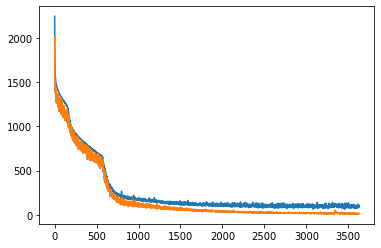

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 11.4526 - val_loss: 100.2182
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 13.8203 - val_loss: 83.3265
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 12.3308 - val_loss: 83.9131
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 14.8197 - val_loss: 85.7571
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 13.6237 - val_loss: 96.7452
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 12.3632 - val_loss: 81.4655
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 12.4689 - val_loss: 92.0071
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 10.8296 - val_loss: 83.5847
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 11.6033 - val_loss: 104.6627
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 9.7933 - val_lo

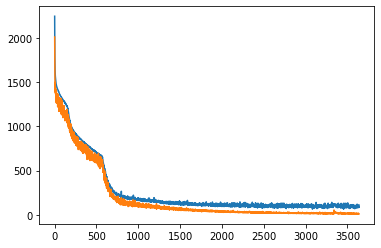

Epoch 1/10
60/60 [==============================] - 141s 2s/step - loss: 12.9634 - val_loss: 106.5290
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 11.6897 - val_loss: 110.2844
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 15.4300 - val_loss: 75.0594
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 13.2874 - val_loss: 87.0620
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 9.1176 - val_loss: 97.7520
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 16.6208 - val_loss: 88.5948
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 11.1289 - val_loss: 104.3419
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 12.3746 - val_loss: 92.6436
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 14.4902 - val_loss: 87.3985
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.4664 - val_l

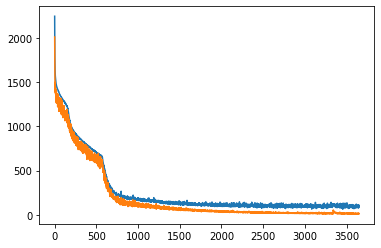

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 13.0326 - val_loss: 113.4699
Epoch 2/10
60/60 [==============================] - 133s 2s/step - loss: 10.7286 - val_loss: 103.0307
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 9.8905 - val_loss: 101.2303
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 13.6485 - val_loss: 101.0266
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 12.5626 - val_loss: 98.8762
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 10.8343 - val_loss: 90.0124
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 10.9097 - val_loss: 97.3820
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 10.2467 - val_loss: 75.1512
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 10.8864 - val_loss: 88.6290
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 10.1778 - val_

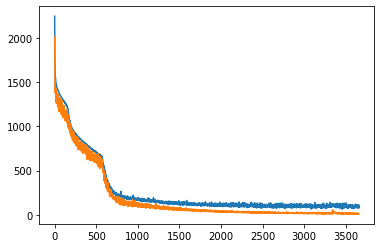

Epoch 1/10
60/60 [==============================] - 141s 2s/step - loss: 9.1925 - val_loss: 81.9866
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 10.7575 - val_loss: 85.5951
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 10.6159 - val_loss: 79.1047
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 8.8022 - val_loss: 102.0361
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 13.7874 - val_loss: 125.3068
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 9.5783 - val_loss: 110.2651
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 10.3331 - val_loss: 86.7394
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 12.7015 - val_loss: 93.6047
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 11.5168 - val_loss: 88.3809
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 21.5166 - val_los

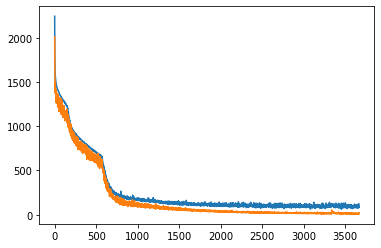

Epoch 1/10
60/60 [==============================] - 141s 2s/step - loss: 20.8827 - val_loss: 115.9409
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 13.2842 - val_loss: 101.8668
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 10.3598 - val_loss: 83.8339
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 16.3718 - val_loss: 69.4822
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 13.0601 - val_loss: 94.7316
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 14.4780 - val_loss: 124.3083
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 10.9945 - val_loss: 117.6565
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 10.8062 - val_loss: 103.1468
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 10.2439 - val_loss: 102.0700
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.2633 - v

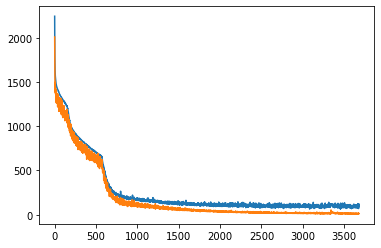

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 11.4788 - val_loss: 97.2998
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 12.3260 - val_loss: 88.0053
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 9.8663 - val_loss: 115.2031
Epoch 4/10
60/60 [==============================] - 132s 2s/step - loss: 10.2505 - val_loss: 105.7626
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 10.1103 - val_loss: 73.6893
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 13.8569 - val_loss: 89.1760
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 10.9028 - val_loss: 81.5875
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 13.1778 - val_loss: 106.8668
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 9.7302 - val_loss: 106.8585
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 10.6442 - val_l

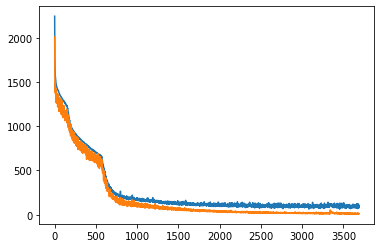

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 10.1454 - val_loss: 99.6851
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 11.0146 - val_loss: 88.3463
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 8.8984 - val_loss: 105.0423
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 11.9625 - val_loss: 95.5437
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 16.1337 - val_loss: 98.6961
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 14.5971 - val_loss: 97.2145
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 11.5315 - val_loss: 83.2872
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 10.2889 - val_loss: 98.6810
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 15.3032 - val_loss: 120.4705
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 9.6307 - val_los

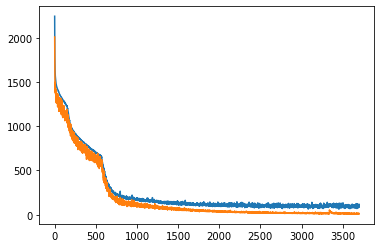

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 11.1147 - val_loss: 81.2339
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 12.3346 - val_loss: 96.8934
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 11.9238 - val_loss: 81.5910
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 10.3056 - val_loss: 88.9214
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 12.0347 - val_loss: 80.7854
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 10.0746 - val_loss: 72.5148
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 11.5385 - val_loss: 74.6413
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 11.1517 - val_loss: 86.9813
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 15.1023 - val_loss: 78.3777
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 10.3337 - val_los

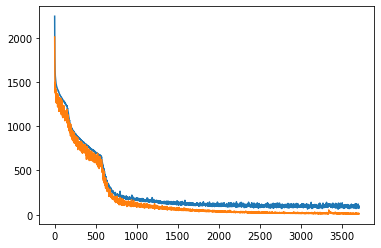

Epoch 1/10
60/60 [==============================] - 141s 2s/step - loss: 11.6618 - val_loss: 92.3994
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 10.5020 - val_loss: 97.4914
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 9.9282 - val_loss: 105.5331
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 9.6583 - val_loss: 88.3153
Epoch 5/10
60/60 [==============================] - 130s 2s/step - loss: 10.9322 - val_loss: 92.1387
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 10.1379 - val_loss: 95.4418
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 9.6095 - val_loss: 90.1508
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 13.5311 - val_loss: 81.7047
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 18.2373 - val_loss: 93.4823
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 12.7030 - val_loss:

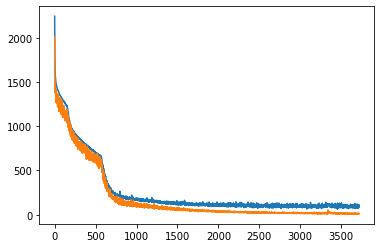

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 12.1591 - val_loss: 82.4778
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 14.5775 - val_loss: 112.6499
Epoch 3/10
60/60 [==============================] - 132s 2s/step - loss: 13.5354 - val_loss: 91.3909
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 13.3954 - val_loss: 82.9642
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 10.3549 - val_loss: 90.6154
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 12.3409 - val_loss: 104.9565
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 9.8612 - val_loss: 99.6942
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 10.7724 - val_loss: 103.4676
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 13.0332 - val_loss: 101.4896
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 10.8471 - val_

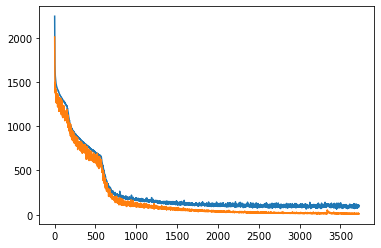

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 13.7875 - val_loss: 82.3029
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 12.1052 - val_loss: 92.7507
Epoch 3/10
60/60 [==============================] - 132s 2s/step - loss: 12.5262 - val_loss: 75.0183
Epoch 4/10
60/60 [==============================] - 132s 2s/step - loss: 12.7145 - val_loss: 69.2607
Epoch 5/10
60/60 [==============================] - 132s 2s/step - loss: 16.8677 - val_loss: 91.2491
Epoch 6/10
60/60 [==============================] - 132s 2s/step - loss: 11.5544 - val_loss: 98.6593
Epoch 7/10
60/60 [==============================] - 132s 2s/step - loss: 10.3176 - val_loss: 95.1068
Epoch 8/10
60/60 [==============================] - 132s 2s/step - loss: 12.1932 - val_loss: 86.7444
Epoch 9/10
60/60 [==============================] - 132s 2s/step - loss: 10.5378 - val_loss: 108.9875
Epoch 10/10
60/60 [==============================] - 132s 2s/step - loss: 9.6062 - val_los

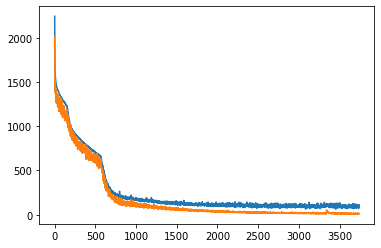

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 10.4233 - val_loss: 110.0911
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 10.6770 - val_loss: 93.4869
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 10.8669 - val_loss: 87.3802
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 14.0965 - val_loss: 100.0952
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 12.0937 - val_loss: 95.0702
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 12.4947 - val_loss: 88.6890
Epoch 7/10
60/60 [==============================] - 134s 2s/step - loss: 11.5915 - val_loss: 79.4833
Epoch 8/10
60/60 [==============================] - 137s 2s/step - loss: 11.8830 - val_loss: 97.7131
Epoch 9/10
60/60 [==============================] - 137s 2s/step - loss: 18.4863 - val_loss: 105.4018
Epoch 10/10
60/60 [==============================] - 138s 2s/step - loss: 16.0326 - val_

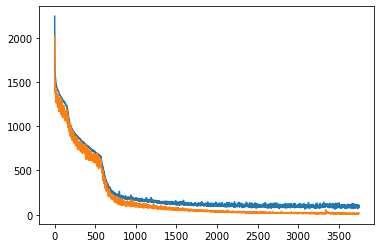

Epoch 1/10
60/60 [==============================] - 146s 2s/step - loss: 11.9535 - val_loss: 116.1768
Epoch 2/10
60/60 [==============================] - 139s 2s/step - loss: 9.4708 - val_loss: 93.4865
Epoch 3/10
60/60 [==============================] - 139s 2s/step - loss: 12.9568 - val_loss: 102.8984
Epoch 4/10
60/60 [==============================] - 138s 2s/step - loss: 9.6963 - val_loss: 92.8250
Epoch 5/10
60/60 [==============================] - 138s 2s/step - loss: 9.5648 - val_loss: 115.2581
Epoch 6/10
60/60 [==============================] - 137s 2s/step - loss: 10.5012 - val_loss: 95.6045
Epoch 7/10
60/60 [==============================] - 137s 2s/step - loss: 10.2924 - val_loss: 107.3065
Epoch 8/10
60/60 [==============================] - 138s 2s/step - loss: 13.5795 - val_loss: 103.7289
Epoch 9/10
60/60 [==============================] - 138s 2s/step - loss: 10.2831 - val_loss: 84.4801
Epoch 10/10
60/60 [==============================] - 138s 2s/step - loss: 10.4597 - val_l

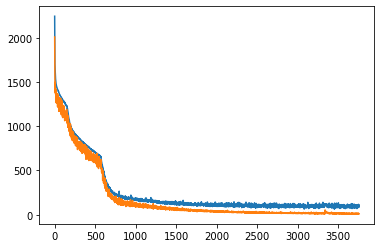

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 14.4484 - val_loss: 82.5847
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 13.4379 - val_loss: 94.9729
Epoch 3/10
60/60 [==============================] - 138s 2s/step - loss: 13.8052 - val_loss: 90.1076
Epoch 4/10
60/60 [==============================] - 138s 2s/step - loss: 12.0893 - val_loss: 107.4674
Epoch 5/10
60/60 [==============================] - 138s 2s/step - loss: 9.5896 - val_loss: 113.5832
Epoch 6/10
60/60 [==============================] - 137s 2s/step - loss: 8.5984 - val_loss: 80.5881
Epoch 7/10
60/60 [==============================] - 137s 2s/step - loss: 9.6840 - val_loss: 85.7140
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 10.2650 - val_loss: 80.9343
Epoch 9/10
60/60 [==============================] - 137s 2s/step - loss: 9.5169 - val_loss: 102.7315
Epoch 10/10
60/60 [==============================] - 137s 2s/step - loss: 10.0947 - val_loss

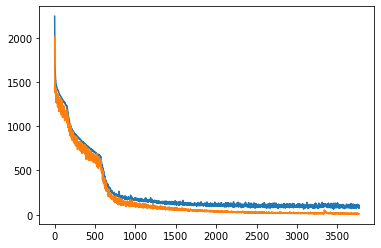

Epoch 1/10
60/60 [==============================] - 148s 2s/step - loss: 10.6625 - val_loss: 87.8064
Epoch 2/10
60/60 [==============================] - 139s 2s/step - loss: 9.7493 - val_loss: 82.4113
Epoch 3/10
60/60 [==============================] - 138s 2s/step - loss: 8.5430 - val_loss: 106.8152
Epoch 4/10
60/60 [==============================] - 137s 2s/step - loss: 13.0921 - val_loss: 76.6766
Epoch 5/10
60/60 [==============================] - 137s 2s/step - loss: 10.9625 - val_loss: 95.5975
Epoch 6/10
60/60 [==============================] - 138s 2s/step - loss: 9.8149 - val_loss: 93.4555
Epoch 7/10
60/60 [==============================] - 137s 2s/step - loss: 8.8116 - val_loss: 95.0992
Epoch 8/10
60/60 [==============================] - 137s 2s/step - loss: 11.3329 - val_loss: 116.6395
Epoch 9/10
60/60 [==============================] - 137s 2s/step - loss: 12.9835 - val_loss: 116.8085
Epoch 10/10
60/60 [==============================] - 137s 2s/step - loss: 13.1532 - val_loss

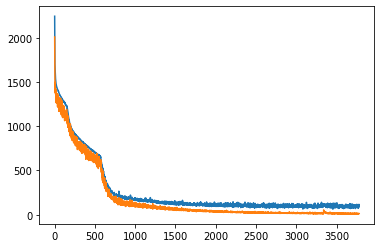

Epoch 1/10
60/60 [==============================] - 146s 2s/step - loss: 10.5448 - val_loss: 85.3072
Epoch 2/10
60/60 [==============================] - 138s 2s/step - loss: 10.4953 - val_loss: 86.6389
Epoch 3/10
60/60 [==============================] - 137s 2s/step - loss: 11.8813 - val_loss: 104.7509
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 11.3990 - val_loss: 88.5478
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 9.8437 - val_loss: 106.0646
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 12.1023 - val_loss: 121.7386
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 14.9684 - val_loss: 112.0756
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 14.0688 - val_loss: 95.7186
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 13.5249 - val_loss: 101.9320
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 17.7385 - val

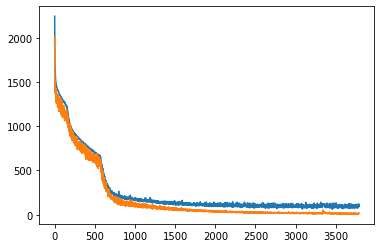

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 10.1696 - val_loss: 78.6622
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 9.1871 - val_loss: 86.6962
Epoch 3/10
60/60 [==============================] - 130s 2s/step - loss: 9.8651 - val_loss: 83.2182
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 10.2833 - val_loss: 92.8263
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 13.3831 - val_loss: 118.3586
Epoch 6/10
60/60 [==============================] - 131s 2s/step - loss: 8.1329 - val_loss: 89.2957
Epoch 7/10
60/60 [==============================] - 131s 2s/step - loss: 9.8673 - val_loss: 88.2526
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 9.3812 - val_loss: 95.2251
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 10.5220 - val_loss: 121.3855
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 13.1740 - val_loss: 

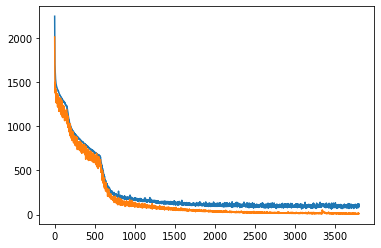

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 9.4337 - val_loss: 96.3149
Epoch 2/10
60/60 [==============================] - 130s 2s/step - loss: 10.1500 - val_loss: 106.1212
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 10.6275 - val_loss: 109.0068
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 9.6513 - val_loss: 95.8538
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 15.7538 - val_loss: 91.3715
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 10.0673 - val_loss: 96.7529
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 9.3443 - val_loss: 104.6057
Epoch 8/10
60/60 [==============================] - 131s 2s/step - loss: 9.0477 - val_loss: 92.1088
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 9.6872 - val_loss: 92.4106
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 10.4509 - val_loss:

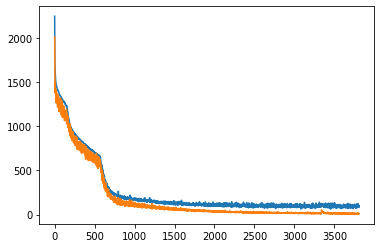

Epoch 1/10
60/60 [==============================] - 139s 2s/step - loss: 8.9165 - val_loss: 110.5969
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 9.6860 - val_loss: 106.4278
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 9.6029 - val_loss: 82.8612
Epoch 4/10
60/60 [==============================] - 130s 2s/step - loss: 10.9055 - val_loss: 95.8357
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 17.9165 - val_loss: 91.4546
Epoch 6/10
60/60 [==============================] - 130s 2s/step - loss: 12.7319 - val_loss: 102.4364
Epoch 7/10
60/60 [==============================] - 130s 2s/step - loss: 10.2361 - val_loss: 86.9388
Epoch 8/10
60/60 [==============================] - 130s 2s/step - loss: 13.0111 - val_loss: 117.6969
Epoch 9/10
60/60 [==============================] - 130s 2s/step - loss: 11.3080 - val_loss: 96.8190
Epoch 10/10
60/60 [==============================] - 130s 2s/step - loss: 12.2357 - val_lo

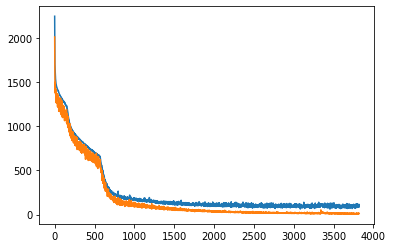

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 13.0114 - val_loss: 96.7984
Epoch 2/10
60/60 [==============================] - 132s 2s/step - loss: 8.4660 - val_loss: 95.8041
Epoch 3/10
60/60 [==============================] - 131s 2s/step - loss: 9.2387 - val_loss: 91.1541
Epoch 4/10
60/60 [==============================] - 131s 2s/step - loss: 11.2317 - val_loss: 102.4109
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 10.9295 - val_loss: 89.6124
Epoch 6/10
60/60 [==============================] - 132s 2s/step - loss: 8.8402 - val_loss: 86.6689
Epoch 7/10
60/60 [==============================] - 132s 2s/step - loss: 10.0055 - val_loss: 80.2481
Epoch 8/10
60/60 [==============================] - 132s 2s/step - loss: 11.4297 - val_loss: 79.4405
Epoch 9/10
60/60 [==============================] - 132s 2s/step - loss: 10.1178 - val_loss: 85.0410
Epoch 10/10
60/60 [==============================] - 131s 2s/step - loss: 17.3568 - val_loss:

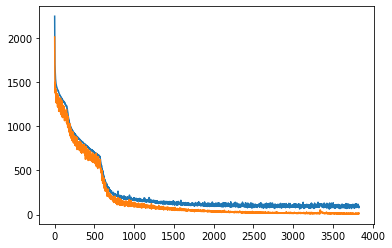

Epoch 1/10
60/60 [==============================] - 140s 2s/step - loss: 12.1362 - val_loss: 82.4317
Epoch 2/10
60/60 [==============================] - 133s 2s/step - loss: 9.2656 - val_loss: 88.9134
Epoch 3/10
60/60 [==============================] - 133s 2s/step - loss: 10.2795 - val_loss: 80.3786
Epoch 4/10
60/60 [==============================] - 132s 2s/step - loss: 16.3644 - val_loss: 79.2740
Epoch 5/10
60/60 [==============================] - 131s 2s/step - loss: 10.8930 - val_loss: 105.2553
Epoch 6/10
60/60 [==============================] - 133s 2s/step - loss: 10.9760 - val_loss: 86.4204
Epoch 7/10
60/60 [==============================] - 133s 2s/step - loss: 16.1769 - val_loss: 86.0576
Epoch 8/10
60/60 [==============================] - 132s 2s/step - loss: 13.4629 - val_loss: 89.7669
Epoch 9/10
60/60 [==============================] - 131s 2s/step - loss: 10.7045 - val_loss: 76.4438
Epoch 10/10
60/60 [==============================] - 132s 2s/step - loss: 8.5923 - val_loss

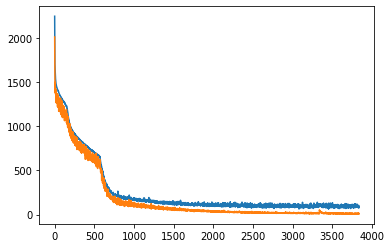

Epoch 1/10
60/60 [==============================] - 142s 2s/step - loss: 8.5461 - val_loss: 89.5997
Epoch 2/10
60/60 [==============================] - 133s 2s/step - loss: 13.1677 - val_loss: 71.8381
Epoch 3/10
60/60 [==============================] - 132s 2s/step - loss: 10.1356 - val_loss: 73.6687
Epoch 4/10
60/60 [==============================] - 132s 2s/step - loss: 10.0342 - val_loss: 101.0166
Epoch 5/10
59/60 [============================>.] - ETA: 2s - loss: 12.5402

In [ ]:
# val_loss_arr  = []
# loss_arr = []

while True:
    
    H = model.fit_generator(generator_train(full_frame_dir),validation_data= return_val(), steps_per_epoch= 60, epochs = 10)
    
    val_loss_arr.append(H.history['val_loss'])
    
    loss_arr.append(H.history['loss'])
    plt.figure()
    plt.plot(np.ravel(np.array(val_loss_arr)))
    plt.plot(np.ravel(np.array(loss_arr)))
    plt.show()

In [90]:
np.save('val_loss_progress.npy', np.ravel(np.array(val_loss_arr)))
np.save('loss_progress.npy', np.ravel(np.array(loss_arr)))

In [333]:
# model.save('train_full_train.h5')

In [61]:
# json_model  = model.to_json()

In [62]:
# import json

# with open('model_arch.json', 'w') as json_file:
#     json.dump(json_model, json_file)


In [91]:
model.save_weights('weights_good_loader.h5')

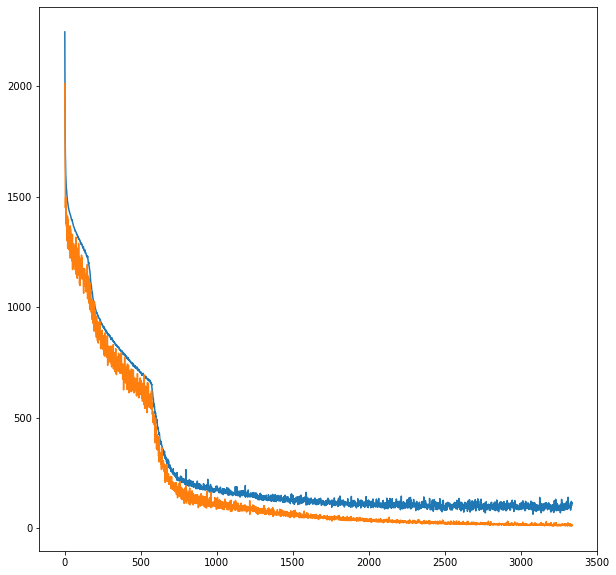

In [93]:
plt.figure( figsize= (10,10))
plt.plot(np.ravel(np.array(val_loss_arr)))
plt.plot(np.ravel(np.array(loss_arr)))
plt.savefig('results/train_good_loader.png')
plt.show()

In [70]:
frame = matr['Matr'][10]
frame = np.reshape(frame,(1,1024,256,80,1))
targets = matr['Labels'][10]
targets = np.reshape(targets, newshape=(1, 20,5))
targets.shape
y_true =  preprocess_true_boxes(targets)
y_true.shape
batch = (frame, y_true)

In [36]:
# model.fit(batch[0], batch[1],batch_size= 1, epochs= 1)

In [291]:
def preprocess_true_boxes(true_boxes , input_shape = (16,8,5), anchors = anchors_list, num_classes = 5 ):
    
    true_boxes = np.array(true_boxes)

    input_shape = (16,8,5)
#     original_input_shape = (1024,256,80)
    original_input_shape = (512,128,40)
    anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    anchors = np.array(anchors)
    
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = np.array(true_boxes[..., 1:3])
    boxes_wh = np.array(true_boxes[..., 3:5])
    
    div_true_boxes_xy = (boxes_xy%(original_input_shape[0:2]/input_shape[0:2]))/(original_input_shape[0:2]/input_shape[0:2])
#     div_true_boxes_xy = boxes_xy
    div_true_boxes_wh = boxes_wh%(original_input_shape[0:2]/input_shape[0:2])
#     div_true_boxes_wh = boxes_wh
    div_true_boxes = np.concatenate((div_true_boxes_xy,div_true_boxes_wh),axis =2)

    true_boxes[..., 1:3] = boxes_xy//(original_input_shape[0:2]/input_shape[0:2][::])
    true_boxes[..., 3:5] = boxes_wh//(original_input_shape[0:2]/input_shape[0:2][::]) #третья координата не добавлена еще

    m = true_boxes.shape[0]
    y_true = np.zeros((m,input_shape[0],input_shape[1],input_shape[2],len(anchors),4+1+num_classes),dtype='float32') 
    anchors = np.expand_dims(anchors, 0)
    anchors = anchors[...,0:2] #здесь изменить потом
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0
    
#     print(true_boxes)
#     print(true_boxes.shape)
#     print(true_boxes[0,:,1:3]*(original_input_shape[0:2]/input_shape[0:2]))
#     print(div_true_boxes_xy[0]*(original_input_shape[0:2]/input_shape[0:2]))
#     print((true_boxes[0,:,1:3]+div_true_boxes_xy)*(original_input_shape[0:2]/input_shape[0:2]))
#     print(y_true.shape)
#     print(np.sum(valid_mask))

    for b in range(m):
        
        wh = boxes_wh[b, valid_mask[b]]
#         print(wh)
        if len(wh)==0: continue
        wh = np.expand_dims(wh, -2)
              
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
#         print(intersect_wh.shape, intersect_wh)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area + 1e-4)
#         print(iou.shape, iou)
        best_anchor = np.argmax(iou, axis=-1)
#         print(best_anchor)
        
#         print(true_boxes[0])
        for t, n in enumerate(best_anchor):
#             i = np.floor(true_boxes[b,t,2]).astype('int32') #обрабатываются только левые границы, а не центры
#             j = np.floor(true_boxes[b,t,1]).astype('int32')
            i = true_boxes[b,t,2].astype('int32')
            j = true_boxes[b,t,1].astype('int32')
            l = int(20//(original_input_shape[2]/input_shape[2]))
#             k = n
            c = 1
            for k in range(len(anchors[0])):
                y_true[b, j, i, l, k, 0:2] = div_true_boxes_xy[b,t,:]
                y_true[b, j, i, l, k, 2:4] = np.log(div_true_boxes_wh[b,t,:]/anchors[0,k]+ 1e-3)
#                 y_true[b, j, i, l, k, 4] = 1*iou[t,k]
                y_true[b, j, i, l, k, 4] = 1
                y_true[b, j, i, l, k, 5+c] = 1

    return y_true

[[[ 24.5  157.75  66.75  20.    44.5 ]
  [ 26.   165.75  19.25  20.    29.5 ]
  [ 26.5  203.25  32.25  17.    50.5 ]
  [ 26.5  293.5   52.75  11.5   29.5 ]
  [ 26.5  324.    84.5   12.5   38.  ]
  [ 26.5  333.5   60.5   13.5   37.  ]
  [ 26.5  354.25  81.5    9.    39.  ]
  [ 26.5  387.25  83.5   18.    59.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]]]
[[[24.5  4.   4.   0.   2. ]
  [26.   5.   1.   0.   1. ]
  [26.5  6.   2.   0.   3. ]
  [26.5  9.   3.   0.   1. ]
  [26.5 10.   5.   0.   2. ]
  [26.5 10.   3.   0.   2. ]
  [26.5 11.   5.   0.   2. ]
  [26.5 12.   5

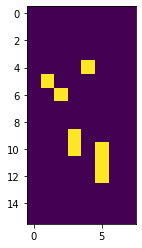

[[150.94437980651855, 72.68581295013428, 20.02000093460083, 12.5450000166893],
 [49.433645248413086,
  88.80971813201904,
  20.02000093460083,
  13.544999957084656],
 [82.78388595581055,
  104.06249904632568,
  17.020000219345093,
  2.5449999421834946],
 [113.37162590026855,
  153.17885494232178,
  11.520000696182251,
  13.544999957084656],
 [115.3258171081543,
  170.97519207000732,
  13.519999980926514,
  5.044999793171883],
 [176.99870109558105,
  169.11764240264893,
  12.519999742507935,
  6.044999733567238],
 [176.56226921081543, 184.3747262954712, 9.020000100135803, 7.044999673962593],
 [176.8118019104004,
  200.87152767181396,
  18.020000457763672,
  11.045000106096268]]

In [288]:
print(targets)
# print(anchors_list)
y_true = preprocess_true_boxes(targets)
new_targets  = decode_netout(y_true,obj_thresh= 0.6)
new_targets[::6]

In [5]:
def loss_mine_tf_2(y_true,y_pred,anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    ignore_thresh  = 0.5
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])
    
    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)
    
    
#     y_true, true_boxes = y_true
#     print(y_true.shape)
#     y_true = y_true[0]
#     print(y_true.shape)
#     true_boxes = y_true[1]
#     print(true_boxes.shape)
    
#     input_image, y_true, true_boxes, y_pred = x
#     input_image = matr["Matr"][0]

#     true_boxes = matr['Labels'][0]
#     true_boxes = true_boxes.reshape((1,true_boxes.shape[0],true_boxestrue_boxes.shape[1]))
#     y_true = preprocess_true_boxes(true_boxes)
#     y_pred = preprocess_true_boxes(true_boxes)

#     print(y_true.shape, y_pred.shape, input_image.shape)

#     print(y_pred.shape)
#     print(tf.concat([tf.shape(y_pred)[1:4], tf.constant([tf.shape(anchors)[3], -1])], axis=0))

    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

    
    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])
   

    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
#     pred_box_xy    = (cell_grid[:grid_h,:grid_w,:grid_d,:,:2] + tf.sigmoid(y_pred[..., :2]))# sigma(t_xy) + c_xy
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
    pred_box_class = K.softmax(y_pred[..., 5:])


    # change_1
#     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
    true_box_xy    = y_true[..., 0:2]
    true_box_wh    = y_true[..., 2:4] # t_wh
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf - 0 

#     true_xy = true_boxes[..., 0:2] / grid_factor[...,:2]
#     true_wh = true_boxes[..., 2:4] / net_factor[...,:2]
#      true_wh = true_boxes[..., 2:4] / (net_factor[...,:2]/grid_factor[...,:2])
    true_xy = true_boxes[..., 0:2] % (net_factor[...,:2]/grid_factor[...,:2])
    true_wh = true_boxes[..., 2:4] % (net_factor[...,:2]/grid_factor[...,:2])

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2]), 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)
    pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2], 4)

#     pred_xy = tf.expand_dims(pred_box_xy / grid_factor[...,:2], 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)

    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious   = tf.reduce_max(iou_scores, axis=4)        
    conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

#     true_xy = true_box_xy / grid_factor[...,:2]
    true_xy = true_box_xy
    true_wh = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]

#     pred_xy = pred_box_xy / grid_factor[...,:2]
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 



    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    # """
    # Compare each true box to all anchor boxes
    # """      

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]/net_factor[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

#     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
#     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
#     print(loss_xy.shape)
#     loss = loss_xy + loss_wh + loss_conf + loss_class
    loss = loss_xy+ loss_wh + loss_conf + loss_class
#         print(loss.shape)

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 
#     loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_conf), 
#                                    tf.reduce_sum(loss_wh), 
#                                    tf.reduce_sum(loss_class)],  message='conf, wh,  class: \t',   summarize=1000)   

    return loss*grid_scale

In [6]:
def mine_loss():
    def yolo_loss(y_true, y_pred):
        return loss_mine_tf_2(y_true, y_pred)
    return yolo_loss

In [7]:
model_loss = mine_loss()

In [33]:
pathname = os.path.abspath('data')

file = glob.glob(pathname+'/*.mat')[0]
matr = scipy.io.loadmat(file)
for num_frame in range(len(matr['Labels'])):
    Labels = np.array(matr["Labels"][num_frame])
    Labels = Labels/2
    object_mask = Labels[:,0]
    if object_mask.shape[0] != 0:
        true_boxes = Labels[:,:]
        targets = np.expand_dims(Labels,0)
        frame = matr["Matr"][num_frame]
        frame = frame[::2,::2,::2]
        frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
        y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))


/home/cognitive-comp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


In [34]:
model_loss([y_true,targets], y_true)

(1, 16, 8, 5, 6, 10)
(1, 20, 5)


<tf.Tensor: id=1228, shape=(), dtype=float32, numpy=3661219.2>

In [297]:
model.load_weights('weights_good_loader.h5')

In [298]:
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat')
frame = matr['Matr'][10]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,512,128,40,1))
targets = abs(matr['Labels'][10])
targets = targets/2
targets = np.reshape(targets, newshape=(1, 20,5))
y_true =  preprocess_true_boxes(targets)
print(frame.shape,targets.shape,y_true.shape)

(1, 512, 128, 40, 1) (1, 20, 5) (1, 16, 8, 5, 6, 10)


In [299]:
y_pred = model.predict([frame,targets])

In [300]:
y_true.shape

(1, 16, 8, 5, 6, 10)

In [301]:
np.unravel_index(y_true.argmax(),y_true.shape)

(0, 4, 4, 2, 0, 4)

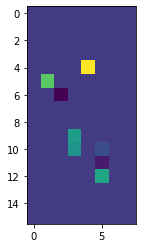

In [302]:
plt.figure()
plt.imshow(np.sum(y_true, axis = (0,3,4,5)))
plt.show()

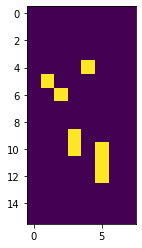

<Figure size 432x288 with 0 Axes>

In [303]:
plt.figure()
plt.imshow(y_true[0,:,:,2,0,4])
plt.show()
plt.savefig('confidence_map.png')

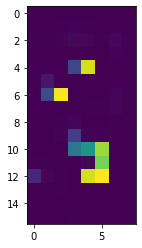

In [304]:
plt.figure()
plt.imshow(_sigmoid(y_pred[0,:,:,2,0,4]))
plt.show()

In [305]:
print((_sigmoid(y_pred[0,:,:,2,0,4])).max(), (_sigmoid(y_pred[0,:,:,2,0,4])).min())

0.87940276 5.9951703e-06


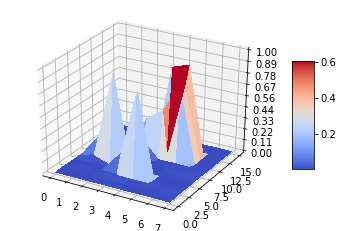

In [112]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

plot3 = y_pred[0,:,:,2,0,4]

X = np.arange(0,plot3.shape[1])
Y = np.arange(0, plot3.shape[0])
X, Y = np.meshgrid(X, Y)
Z = _sigmoid(plot3)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

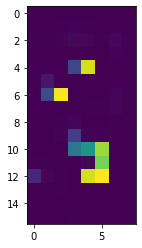

In [113]:
plt.figure()
plt.imshow(Z)
plt.show()
# plt.savefig('confidence_map_prediction.png')

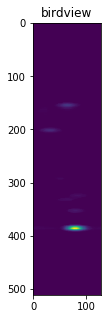

In [306]:
birdview_frame = np.sum(frame, axis = (0,3,4))
plt.figure(figsize= (5,5))
plt.imshow(birdview_frame)
plt.title('birdview')
plt.show()

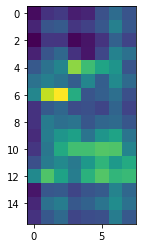

In [307]:
plt.figure()
plt.imshow(y_pred[0,:,:,2,0,6])
plt.show()

In [295]:
def decode_netout(netout,  obj_thresh = 0.63, anchors=  anchors_list,):
    input_shape = (16,8,5)
    original_input_shape = (512,128,40)
    
    anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    grid_h, grid_w,grid_d = netout.shape[1:4]
#     print(grid_h, grid_w, grid_d)
    num_boxes = len(anchors)
#     print(num_boxes)
    netout = netout.reshape((grid_h, grid_w, grid_d,num_boxes, -1))
#     print(netout.shape)
    nb_class = netout.shape[-1] - 5
    
    boxes = []

#     netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    
#     plt.figure()
#     plt.imshow(netout[:,:,2,0,4])
#     plt.show()
    
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for row in range(grid_h):
        for col in range(grid_w):
            for dep in range(grid_d):
                for b in range(num_boxes):
                    objectness = netout[row, col,dep, b, 4]
                    
                    if(objectness <= obj_thresh): continue
                    
                    x, y, w, h = netout[row,col,dep,b,:4]
                    x = (row + x)*(original_input_shape[0]/input_shape[0]) 
                    y = (col + y)*(original_input_shape[1]/input_shape[1])
                    w = anchors[b][0] * np.exp(w) 
                    h = anchors[b][1] * np.exp(h)   
                    classes = netout[row,col,dep,b,5:]
                    box = [x,y,w,h]
                    boxes.append(box)
#                     box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
#                     boxes.append(box)

    return boxes


In [296]:
print(targets)
y_true = preprocess_true_boxes(targets)
print('\n\n\n\n\n\n\n\n\n\n')
new_targets  = decode_netout(y_true,obj_thresh= 0.72)
new_targets[::6]

[[[ 24.5  157.75  66.75  20.    44.5 ]
  [ 26.   165.75  19.25  20.    29.5 ]
  [ 26.5  203.25  32.25  17.    50.5 ]
  [ 26.5  293.5   52.75  11.5   29.5 ]
  [ 26.5  324.    84.5   12.5   38.  ]
  [ 26.5  333.5   60.5   13.5   37.  ]
  [ 26.5  354.25  81.5    9.    39.  ]
  [ 26.5  387.25  83.5   18.    59.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]]]













[[157.75, 66.75, 20.02000093460083, 12.5450000166893],
 [165.75, 19.25, 20.02000093460083, 13.544999957084656],
 [203.25, 32.25, 17.020000219345093, 2.5449999421834946],
 [293.5, 52.75, 11.520000696182251, 13.544999957084656],
 [333.5, 60.5, 13.519999980926514, 5.044999793171883],
 [324.0, 84.5, 12.519999742507935, 6.044999733567238],
 [354.25, 81.5, 9.020000100135803, 7.044999673962593],
 [387.25, 83.5, 18.020000457763672, 11.045000106096268]]

In [230]:
y_true.shape

(1, 16, 8, 5, 6, 10)

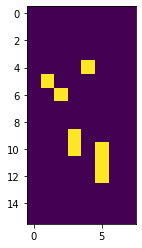

In [234]:
plt.figure()
plt.imshow(y_true[0,:,:,2,1,4])
plt.show()

In [244]:
coords = y_true[0,4,4,2,2,:4]

In [249]:
[32,16]*(coords[:2]+ [4,4])

array([150.94437981,  72.68581295])

In [250]:
np.exp(coords[2:4])*

array([1.4295714, 0.3135   ], dtype=float32)

In [315]:
boxes = decode_netout(y_pred, 0.5)

In [316]:
len(boxes)

3840

In [311]:
pprint.pprint(boxes[::6])

[[186.51143646240234, 37.56010627746582, 3.947172164916992, 9.115924537181854],
 [175.83864402770996,
  15.300914764404297,
  3.8335782289505005,
  2.769320122897625],
 [325.25070571899414, 74.06605625152588, 4.820193946361542, 5.673533231019974],
 [350.29568111896515, 57.26326370239258, 4.935204088687897, 9.723722487688065],
 [324.2833709716797, 87.94005012512207, 5.574406385421753, 8.982730060815811],
 [354.40614128112793, 69.65460586547852, 4.020180702209473, 6.50643490254879]]


In [122]:
targets

array([[[ 24.5 , 157.75,  66.75,  20.  ,  44.5 ],
        [ 26.  , 165.75,  19.25,  20.  ,  29.5 ],
        [ 26.5 , 203.25,  32.25,  17.  ,  50.5 ],
        [ 26.5 , 293.5 ,  52.75,  11.5 ,  29.5 ],
        [ 26.5 , 324.  ,  84.5 ,  12.5 ,  38.  ],
        [ 26.5 , 333.5 ,  60.5 ,  13.5 ,  37.  ],
        [ 26.5 , 354.25,  81.5 ,   9.  ,  39.  ],
        [ 26.5 , 387.25,  83.5 ,  18.  ,  59.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ]]]

2.1209357 -6.930343


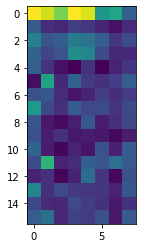

In [123]:
Y_pred = np.copy(y_pred)
Y_pred = (Y_pred - Y_pred.mean())/(Y_pred.std())
# Y_pred /= Y_pred.max()
print(Y_pred.max(), Y_pred.min())
plt.figure()
plt.imshow(_sigmoid(Y_pred[0,:,:,2,0,2]))
plt.show()

In [124]:
targets[0,0]

array([ 24.5 , 157.75,  66.75,  20.  ,  44.5 ])

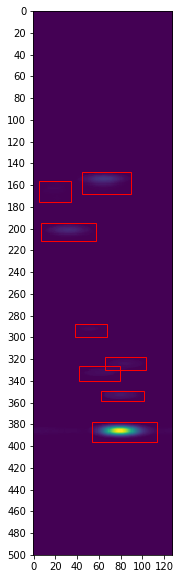

In [317]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.sum(frame,axis = (0,3,4))

# Create figure and axes
fig,ax = plt.subplots(1,figsize = (10,10))

# Display the image
ax.imshow(im)

# Create a Rectangle patch
x_ticks = np.arange(0, im.shape[1], 20)
y_ticks = np.arange(0, im.shape[0], 20)

ax.set_xticks(x_ticks)
# ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(y_ticks)
# ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
# ax.grid(which='both')

for num_target in range(targets.shape[1]):
    x = targets[0,num_target,2]
    y = targets[0,num_target,1]
    w = targets[0,num_target,4]
    h = targets[0,num_target,3]
    x_t = x-w/2
    x_b = x+w/2 
    y_t = y-h/2
    y_b = y+h/2
    rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
#     rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


-17.6068497300148 -16.502655148506165 32.045482993125916 15.685192346572876
0.6687951683998108 -11.601482272148132 14.573881030082703 12.124284505844116
-7.824374675750732 -10.585878491401672 24.99952793121338 7.280839204788208
-17.37414562702179 -4.976876258850098 34.313950538635254 10.46271800994873
-15.209347367286682 -12.973706483840942 32.81381607055664 6.004230976104736
-10.076005399227142 -4.310077369213104 17.551998496055603 21.281728148460388
-18.804736375808716 -15.42989182472229 24.157540798187256 15.138609409332275
-2.034398525953293 -13.69293487071991 13.674016892910004 13.150752782821655
-12.057622790336609 -11.817841917276382 25.07730007171631 6.010783016681671
-16.878017783164978 -10.020559430122375 27.677453756332397 8.755961656570435
-19.850510597229004 -18.83253586292267 30.1332426071167 4.162050485610962
-9.762749195098877 -5.958596050739288 16.5718674659729 16.35421335697174
-16.57574474811554 -2.852029860019684 12.364307641983032 8.949550986289978
-16.122740626335

29.404086142778397 27.083191752433777 17.138143479824066 12.25693941116333
36.86825680732727 20.298948168754578 9.981687068939209 12.567993402481079
33.38685929775238 16.203205168247223 17.347031831741333 7.519445300102234
28.551272094249725 20.337231934070587 23.22923719882965 9.694613814353943
26.82678532600403 16.305759847164154 15.00098466873169 4.9357157945632935
32.62739351391792 17.262803971767426 10.840094983577728 18.717640042304993
29.120845556259155 29.881852865219116 44.69493627548218 19.522736072540283
47.45725327730179 27.056801438331604 18.779634833335876 16.518369913101196
39.72229599952698 26.67570596933365 35.11173963546753 9.820347428321838
27.558166027069092 36.43377614021301 53.49723815917969 12.51554250717163
31.317365407943726 25.71392434835434 37.53396272659302 7.202222943305969
40.6604260802269 32.4693945646286 22.34894335269928 27.768112421035767
37.6113803088665 34.054396748542786 23.503996431827545 13.675731420516968
53.32281383872032 28.160844802856445 12.4

50.786901354789734 58.667010843753815 28.483712673187256 6.03709876537323
57.070975840091705 59.785953104496 18.371803164482117 20.475327372550964
68.11994233727455 40.771329045295715 28.570866286754608 17.691396474838257
81.26942938566208 39.673113107681274 15.160279870033264 16.431472301483154
75.33890008926392 40.16085088253021 26.991829872131348 8.308326005935669
67.72124326229095 51.92796242237091 36.68052792549133 11.042832136154175
66.39359724521637 38.135109543800354 30.007550716400146 5.571249723434448
77.24782913923264 46.16349458694458 17.418370842933655 20.72303295135498
72.08476093411446 55.8180136680603 19.614069163799286 13.274422883987427
86.52029591798782 51.88398551940918 10.992187857627869 13.182754516601562
78.80650973320007 58.67981216311455 20.924293994903564 5.591435968875885
75.70265853404999 56.83213818073273 24.517475366592407 7.152994871139526
69.54576194286346 47.630467623472214 23.73927354812622 3.1315436959266663
84.64912158250809 64.33012014627457 12.8124

98.99735271930695 96.48379281163216 16.07511878013611 4.45364373922348
93.78416812419891 106.5881838798523 18.759037256240845 8.154606819152832
91.37832772731781 95.91617080569267 17.739378213882446 4.160511791706085
97.22166347503662 98.35890716314316 12.302613258361816 10.57183563709259
102.91545939445496 72.53483498096466 25.306813716888428 15.045274496078491
115.93496769666672 70.7681086063385 15.235281586647034 15.380542278289795
109.9616584777832 71.20886075496674 22.86090850830078 8.769084215164185
102.01382005214691 80.48105299472809 33.957635164260864 11.475638151168823
104.27721881866455 68.72443288564682 26.38390064239502 5.617159008979797
109.46471500396729 73.27390950918198 15.402917861938477 19.63651478290558
114.16854050755501 76.12699794769287 15.057564675807953 13.559150695800781
125.42693328857422 72.2046457529068 9.27572250366211 13.77139925956726
119.81685245037079 75.84413748979568 13.817859888076782 7.226931929588318
115.65057522058487 76.18379855155945 18.0148762

-4.731332838535309 155.80187556147575 23.836353421211243 4.996189177036285
-0.9719424247741699 180.27050149440765 31.395745277404785 2.888432741165161
-1.1590714156627655 169.01672549545765 11.705118119716644 5.699707120656967
4.661599323153496 189.45711505413055 16.016318947076797 13.13153862953186
10.709119737148285 179.78449726104736 12.87863552570343 14.869966506958008
8.119398713111877 187.95557302236557 18.01181674003601 6.643228650093079
0.8634237051010132 196.40119510889053 24.49297070503235 9.62667167186737
-1.347574234008789 193.37115305662155 25.244131088256836 4.889102578163147
6.120602041482925 193.40897527337074 12.450253665447235 13.956532180309296
-16.012079030275345 192.8315989971161 33.55778485536575 18.56212854385376
0.055831193923950195 193.3871270418167 19.208314418792725 13.592170476913452
-8.294967651367188 199.5557849407196 27.925944328308105 6.404001712799072
-15.018679976463318 202.30512273311615 34.52149271965027 11.477500200271606
-20.54832172393799 196.3046

-1.5517126321792603 196.7850061058998 31.42094135284424 9.364725947380066
2.8545998334884644 206.68357062339783 29.019875526428223 5.097076892852783
10.990960568189621 205.4360013604164 11.75898402929306 17.188956141471863
15.062908455729485 158.20233154296875 16.450225263834 10.968914031982422
29.436582326889038 155.07960212230682 10.1798415184021 10.480562448501587
21.916906714439392 153.98720064759254 16.282637119293213 5.500902354717255
14.853485643863678 165.400665640831 25.074822306632996 8.708010911941528
13.449167251586914 153.4460945725441 25.570006370544434 5.264884829521179
21.29980543255806 164.0117824971676 11.476758420467377 14.674539864063263
14.857661724090576 155.9537628889084 14.658894538879395 9.138799905776978
31.992910355329514 147.53973925113678 10.94259649515152 10.500096082687378
21.505406379699707 162.47845482826233 13.267931938171387 5.446670055389404
15.59031230211258 154.37198638916016 22.831773161888123 7.437591552734375
13.431621789932251 160.1109260320663

42.20788587629795 225.83202373981476 20.17869159579277 13.76613974571228
48.7842658162117 208.88304376602173 15.633296370506287 19.015421867370605
45.170711278915405 220.93579006195068 23.4374737739563 11.281987190246582
37.02239406108856 220.0409723520279 39.63572144508362 13.068994283676147
39.20378136634827 224.54012513160706 28.339040279388428 6.441981792449951
48.591626673936844 215.2210209965706 14.756399095058441 22.389973998069763
53.94352796673775 218.25935077667236 32.506278455257416 15.684683322906494
67.09704065322876 217.05761885643005 18.28758716583252 14.35171127319336
60.32444667816162 220.3734923005104 30.934467315673828 7.59132444858551
52.37150752544403 225.3177205324173 41.67385697364807 10.92267394065857
52.13859748840332 216.88252687454224 37.14086055755615 5.739579200744629
61.33487677574158 223.6238734126091 21.145169734954834 19.426050782203674
53.859236896038055 226.4639618396759 20.888488590717316 11.711394786834717
70.2342956662178 224.72888898849487 12.3445

51.99873524904251 249.85454940795898 26.53288185596466 12.273802757263184
52.78378474712372 244.80576395988464 23.209028244018555 6.265223026275635
58.08310467004776 245.68487840890884 13.390899896621704 21.068864464759827
55.104237362742424 253.26837694644928 19.555246978998184 12.701588869094849
65.32171627879143 249.77280271053314 12.72611528635025 12.139281034469604
59.88384246826172 250.53894966840744 20.37487030029297 6.607930779457092
54.8417032957077 258.5782628059387 26.199742555618286 9.768075942993164
54.41972196102142 250.06237316131592 22.153115272521973 5.052347183227539
60.405988454818726 250.91998821496964 14.129776954650879 16.045090556144714
68.60092774033546 222.0662738084793 24.236019551753998 17.878202199935913
83.30465304851532 219.93256723880768 10.960947275161743 16.451557874679565
77.56396722793579 220.41244119405746 21.61141872406006 8.711700558662415
70.11377501487732 231.81233131885529 31.411221027374268 10.7907235622406
68.79232823848724 217.02443450689316 

107.77942302823067 278.10685646533966 9.92445319890976 14.076930284500122
103.77693593502045 279.12577879428864 16.546355485916138 6.662690877914429
100.6703707575798 285.360864341259 21.997995972633362 9.045148491859436
97.29243159294128 271.6765076816082 15.935757160186768 3.7083497643470764
106.10339733958244 273.9490384757519 10.23372083902359 12.842687666416168
90.56505753099918 276.91819190979004 11.907617300748825 10.842514038085938
103.61226254701614 267.8714874982834 9.61211621761322 13.62627625465393
96.37133526802063 282.44292691349983 14.627583026885986 5.71488755941391
96.51252418756485 273.9278964996338 18.653399348258972 7.599010467529297
91.42641341686249 267.4645916223526 19.582635164260864 3.0721938610076904
103.25946766138077 279.73412880301476 9.56335723400116 11.69641524553299
91.98376503586769 279.1574238240719 3.26731413602829 2.5728419423103333
81.91508108377457 263.0054654479027 10.207130312919617 6.939600110054016
84.27379184961319 280.02442157268524 5.4939430

95.28693747520447 328.49875968694687 33.203197717666626 9.92577850818634
95.44492197036743 326.9166189432144 38.66323471069336 5.834149122238159
100.64187955856323 325.1038939654827 21.851972937583923 13.132559359073639
-10.731118649244308 360.71921169757843 26.020804345607758 14.032424688339233
3.4383482336997986 355.003408908844 15.21066963672638 14.236435890197754
-3.639354705810547 358.51829558610916 22.6607084274292 8.095803618431091
-11.248075127601624 362.60427498817444 32.49402165412903 9.848811626434326
-9.743751049041748 357.0359954535961 26.117630004882812 4.799799025058746
-3.564094454050064 360.83175951242447 14.840650856494904 18.65684688091278
-10.61325840651989 364.1141792535782 15.501943677663803 12.134464979171753
3.920354664325714 360.6489335298538 12.030252814292908 12.205671072006226
-4.6856688261032104 360.06974679231644 16.580599546432495 4.912773489952087
-9.000357866287231 366.2562141418457 16.652451753616333 6.467933654785156
-12.456958293914795 357.7908412218

-10.039803266525269 363.1849800348282 31.487481594085693 11.304901838302612
-7.971381664276123 367.4082885980606 29.799633026123047 5.5772387981414795
0.37289363145828247 362.1021076440811 14.15653645992279 18.13567042350769
-14.136319905519485 398.7960394024849 19.554196894168854 6.980823874473572
2.72141370177269 391.12093794345856 12.568605244159698 7.193535566329956
-9.075575709342957 409.89379930496216 21.446728706359863 4.320479393005371
-12.03643000125885 385.31536853313446 29.82016682624817 6.7309486865997314
-11.16273808479309 394.9156531393528 31.96890115737915 3.628980815410614
-3.206443190574646 402.1249013543129 15.485347509384155 12.289683222770691
-3.377408742904663 317.76124382019043 19.744298458099365 24.877490997314453
17.799023240804672 319.1274173259735 11.056583225727081 21.573870182037354
5.989353060722351 331.38132363557816 14.89101529121399 10.986276984214783
0.9009066224098206 328.9732072353363 20.134121775627136 14.952518939971924
3.2388702630996704 328.613720

30.254415333271027 383.11189928650856 11.586865782737732 9.275362193584442
25.798101007938385 402.13583612442017 16.800257563591003 12.097716331481934
33.330469369888306 398.06104266643524 9.384233951568604 11.906810998916626
29.759433388710022 400.8106854259968 17.509082555770874 6.915666043758392
24.60342562198639 399.43560618162155 23.503164052963257 9.702582955360413
23.578079223632812 399.2313058376312 17.858914136886597 5.1680588722229
30.895102500915527 401.5935438275337 11.442975997924805 18.524946570396423
27.09174072742462 417.568823993206 13.255691528320312 9.860807061195374
36.999192267656326 413.5637798309326 8.342901170253754 10.34106969833374
31.534934043884277 412.91286700963974 14.632735252380371 5.865068316459656
26.64679390192032 411.2793518304825 18.10372531414032 7.887338399887085
25.946882486343384 409.49538257718086 13.916903734207153 3.7383970618247986
30.586093604564667 412.33393555879593 9.28079903125763 14.502577185630798
22.366722583770752 414.21003103256226

29.136255621910095 425.7222113609314 44.10267949104309 12.429146766662598
30.759073853492737 417.95907229185104 31.622579097747803 7.002692818641663
41.279796957969666 426.6013085246086 17.886124849319458 28.58020842075348
29.66634638607502 425.8152780532837 20.476400703191757 14.619970321655273
47.31755834817886 422.3260431289673 9.101530909538269 13.170175552368164
38.997008085250854 429.5945061147213 21.054303646087646 6.028730690479279
35.35980439186096 429.1468681693077 26.44621968269348 7.763732075691223
30.384284734725952 417.04116982221603 23.81960153579712 3.8684850931167603
43.969314604997635 436.082037627697 12.315917909145355 17.88830816745758
36.174050502479076 457.25570088624954 8.300716057419777 4.605860114097595
28.342954754829407 444.29391568899155 14.747718572616577 7.431483864784241
30.866934299468994 465.0560829937458 9.415068626403809 5.012231290340424
27.550774216651917 462.10489773750305 20.333250761032104 9.546277523040771
30.052167654037476 479.9685624241829 24

77.95254528522491 464.17372834682465 17.27305293083191 8.053860902786255
71.42674559354782 476.21271002292633 23.670020699501038 11.614164113998413
70.47521162033081 463.8595480918884 16.382063627243042 6.70870304107666
74.94068902730942 466.9841002225876 10.74303388595581 23.014812469482422
72.40473632514477 467.11925077438354 21.55316010117531 16.019415855407715
84.78827038407326 460.67781579494476 12.875401675701141 16.546584367752075
78.85599446296692 463.58219105005264 20.432002544403076 8.36192786693573
72.13084000349045 470.58282029628754 27.890387177467346 10.251632928848267
71.07286071777344 464.4855861067772 23.65255832672119 5.010889172554016
78.846688747406 469.98441153764725 12.895088195800781 19.511016011238098
71.3427374213934 463.64541935920715 12.922739535570145 4.786279201507568
63.602980613708496 451.0781195163727 24.074292182922363 9.421451091766357
67.00396013259888 464.9790391921997 14.559564590454102 6.263481140136719
56.53673458099365 465.7561225891113 32.964076

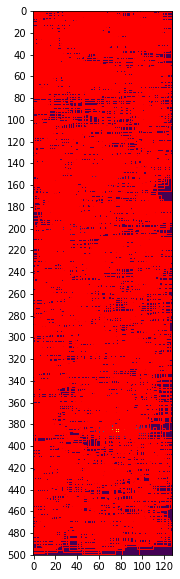

In [319]:
im = np.sum(frame,axis = (0,3,4))

# Create figure and axes
fig,ax = plt.subplots(1,figsize = (10,10))

# Display the image
ax.imshow(im)

# Create a Rectangle patch
x_ticks = np.arange(0, im.shape[1], 20)
y_ticks = np.arange(0, im.shape[0], 20)

ax.set_xticks(x_ticks)
# ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(y_ticks)
# ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
# ax.grid(which='both')

for box in boxes:
#     print(box)
    x = box[1]
    y = box[0]
    w = box[3]
    h = box[2]
    x_t = x-w/2
    x_b = x+w/2 
    y_t = y-h/2
    y_b = y+h/2
    print(x_t,y_t,w,h)
    rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()


In [271]:
pathname = os.path.abspath('data')
counter_frames = 0 
counter_boxes = 0
for file in glob.glob(pathname+'/*.mat'):
    matr = scipy.io.loadmat(file)
    for num_frame in range(len(matr['Labels'])):
        Labels = np.array(matr["Labels"][num_frame])
        Labels = Labels/2
        object_mask = Labels[Labels[:,0]>0,:]
        if object_mask.shape[0] != 0:
            counter_frames += 1
            counter_boxes += object_mask.shape[0]
        
print(counter_frames,counter_boxes)

917 2496


# Visualisation

In [273]:
def render_bird_view(frame):
    plt.figure()
    plt.imshow(np.sum(frame, axis = (0,3,4,5)))
    plt.show()

In [ ]:
def box_draw():
    

In [290]:
def vis_conflevels(y_pred):
    
    levels = []

    for ind in range(y_pred.shape[4]):
        level = y_pred[0,:,:,2,ind,4] + ind
        levels.append(level)
        
    data = [go.Surface(z=level, opacity= 0.9) for level in levels]

    fig = go.Figure(data = data)
    fig.show()

In [93]:
matr_val = frame[0,:,:,:,0]
# targets
print(matr_val.shape)
matr_val = ((matr_val - matr_val.min())/(matr_val.max() - matr_val.min()))

(512, 128, 40)


In [98]:
matr_np_cadr = np.zeros((512,128,40))
for i in range(512):
    for j in range(128):
        for k in range(40):
            if matr_val[i,j,k] > 0.0007:
                matr_np_cadr[i,j,k] = 1
matr_np_cadr.sum()

46596.0

<IPython.core.display.Javascript object>


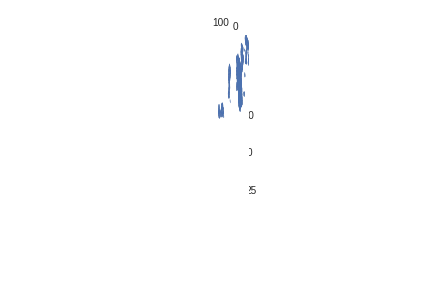

CPU times: user 49.6 s, sys: 303 ms, total: 49.9 s
Wall time: 49.7 s


In [99]:
%%time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels((matr_np_cadr[:,:,:]))
plt.show()

In [101]:
frame = frame[0,:,:,:,0]

<IPython.core.display.Javascript object>


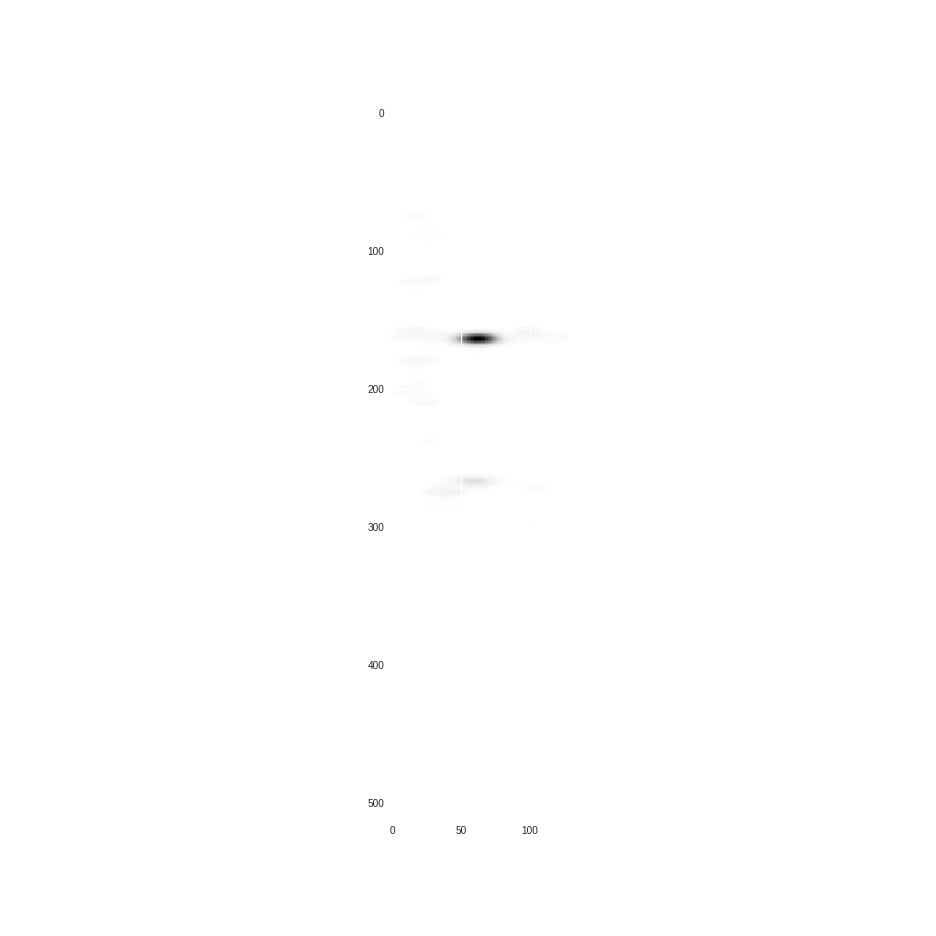

In [105]:
plt.figure(figsize = (13,13))
plt.imshow(np.(frame,axis = -1))
plt.show()

In [485]:
import ipyvolume as ipv
from ipyvolume.pylab import figure
# V = np.zeros((128,128,128)) # our 3d array
V = frame[0,...,0]

f = figure()
ipv.quickvolshow(V, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.show()

In [2]:
import ipyvolume as ipv
import numpy as np
x, y, z = np.random.random((3, 10000))
ipv.quickscatter(x, y, z, size=1, marker="sphere")

In [4]:
import ipyvolume as ipv 

ds = ipv.datasets.aquariusA2.fetch()
fig = ipv.figure(debug=True)
s = 4
v0 = ipv.volshow(ds.data[::s,::s,::s], extent=[[0,100]]*3)
v1 = ipv.volshow(ds.data[::s,::s,::s], extent=[[75,175]]*3)
ipv.show()

/home/cognitive-comp/.local/lib/python3.6/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


# Модель 2

In [36]:
class Yolo_layer(Layer):
    def __init__(self,max_grid,ignore_thresh, obj_scale, noobj_scale, xy_scale, class_scale,anchors):
        max_grid_h, max_grid_w, max_grid_d = max_grid
        self.ignore_thresh  = 0.5
        self.warmup_batches = 1
        self.grid_scale     = 1
        self.obj_scale      = 5
        self.noobj_scale    = 1
        self.xywh_scale     = 1
        self.class_scale    = 1
        self.obj_thresh = 0.6
        self.anchors  = anchors = tf.cast(anchors, dtype = tf.float32)
        self.anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
        
        cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
        cell_y = tf.transpose(cell_x, (1,2,0,3,4))
        cell_z = tf.transpose(cell_x, (2,0,1,3,4))

        self.cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,self.anchors.shape[3],1])

        super(Yolo_layer, self).__init__()
        
        
    def call(self,x):
        input_image, y_true, true_boxes, y_pred = x

        y_true = K.reshape(y_true, tf.shape(y_true[0,...]))
        y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])
        object_mask     = tf.expand_dims(y_true[..., 4], 4)      
        
        grid_h      = tf.shape(y_true)[0]
        grid_w      = tf.shape(y_true)[1]
        grid_d      = tf.shape(y_true)[2]
        grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

        net_h       = tf.shape(input_image)[0]
        net_w       = tf.shape(input_image)[1] 
        net_d       = tf.shape(input_image)[2]
        net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


        pred_box_xy    = (self.cell_grid[:grid_h,:grid_w,:grid_d,:,:2] + tf.sigmoid(y_pred[..., :2]))  # sigma(t_xy) + c_xy
        pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
        pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
        pred_box_class = K.softmax(y_pred[..., 5:])
        
        true_box_xy    = y_true[..., 0:2] + (self.cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
        true_box_wh    = y_true[..., 2:4] # t_wh
        true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
        true_box_class = y_true[...,5:]
        true_box_class = tf.argmax(y_true[...,5:],axis= -1)

        conf_delta  = pred_box_conf - 0 

        true_xy = true_boxes[..., 0:2]
        true_wh = true_boxes[..., 2:4]
#         true_xy = true_boxes[..., 0:2] / grid_factor[...,:2]
#         true_wh = true_boxes[..., 2:4] / net_factor[...,:2]

        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half

        pred_xy = tf.expand_dims(pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2]), 4)
        pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * self.anchors[...,:2], 4)
    #     pred_xy = tf.expand_dims(pred_box_xy / grid_factor[...,:2], 4)
    #     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)

        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half    

        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)

        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)

        best_ious   = tf.reduce_max(iou_scores, axis=4)        
        conf_delta *= tf.expand_dims(tf.to_float(best_ious < self.ignore_thresh), 4)

        true_xy = true_box_xy
        true_wh = tf.exp(true_box_wh) * self.anchors[...,:2]
#         true_xy = true_box_xy / grid_factor[...,:2]
#         true_wh = tf.exp(true_box_wh) * self.anchors[...,:2] / net_factor[...,:2]

        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half

        pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
        pred_wh = tf.exp(pred_box_wh) * self.anchors[...,:2] 
    #     pred_xy = pred_box_xy / grid_factor[...,:2]
    #     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half      

        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)
        iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

        count       = tf.reduce_sum(object_mask)
        count_noobj = tf.reduce_sum(1 - object_mask)
        detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
        class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
        recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
        recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
        avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
        avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
        avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
        avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 



        true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

        # """
        # Compare each true box to all anchor boxes
        # """      

        wh_scale = tf.exp(true_box_wh) * self.anchors[...,:2]/net_factor[...,:2]
        wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the
    #     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
    #     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

        pred_box_wh = pred_box_wh/net_factor[...,:2]
        true_box_wh = true_box_wh/net_factor[...,:2]
        
        xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * self.xywh_scale/10000
        wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * self.xywh_scale
        conf_delta  = object_mask * (pred_box_conf-true_box_conf) * self.obj_scale + (1-object_mask) * conf_delta * self.noobj_scale
        class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
    #     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale
        
        loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
        loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
        loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
        loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
        loss = loss_xy + loss_wh + loss_conf + loss_class

        loss = tf.Print(loss,[grid_h, tf.reduce_max(pred_box_wh),tf.reduce_max(true_box_wh)],summarize = 1000)
#         loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
#         loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
#         loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
#         loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
#         loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
#         loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
#         loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
        loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                       tf.reduce_sum(loss_wh), 
                                       tf.reduce_sum(loss_conf), 
                                       tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000)   

        return loss*self.grid_scale

In [37]:
def get_model_2():
    input_image = layers.Input(shape=(IMAGE_H/2,IMAGE_W/2,IMAGE_D/2,1))
    true_boxes  = layers.Input(shape=(1, 1, 1, 20, 5))
    y_true = layers.Input(shape=(None, None,None, num_boxes, 4+1+num_classes)) 
    
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same', name = 'conv_0_1')(input_image)
    x = layers.BatchNormalization(name='norm_0_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(2,2,1))(x)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same',name = 'conv_1_1')(x)
    x = layers.BatchNormalization(name='norm_1_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,4,4))(x)

    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same')(x)
    x = layers.BatchNormalization(name='norm_5_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,2,2))(x)
    
    x = layers.Conv3D(filters = (4+1+num_classes)*num_boxes, kernel_size=(1,1,1), strides =(1,1,1), padding = 'same', name= 'yolo')(x)
    output = layers.Reshape((GRID_H,GRID_W,GRID_D,num_boxes, 4+1+num_classes))(x)
    
    loss = Yolo_layer((16,16,16),0.5,5,1,1,1,anchors_list)([input_image, y_true, true_boxes,output])

    
    model = models.Model([input_image,true_boxes, y_true],loss)
#     model = models.Model([input_image, true_boxes, y_true],loss)
    return model

In [38]:
def dummy_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(y_pred))

model_test = get_model_2()

mypotim=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model_test.compile(loss=dummy_loss, optimizer=mypotim)

In [19]:
pathname = os.path.abspath('data')
def generator(pathname = pathname):
    while True:
        for file in glob.glob(pathname+'/*.mat'):
            matr = scipy.io.loadmat(file)
            for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
                    true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
                    targets = targets/2
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
                    true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                    yield ([frame,true_boxes,y_true], true_boxes )

In [28]:
file_arr = glob.glob(pathname+'/*.mat')
file = file_arr[0]
matr = scipy.io.loadmat(file)
Labels = np.array(matr["Labels"][19])
object_mask = Labels[:,0]


In [29]:
Labels

array([[ 51.        , 275.43346008,  42.56273764,  35.80228137,
         84.62357414],
       [ 53.        , 315.71102662,  30.35741445,  20.34220532,
         60.21292776],
       [ 49.        , 318.96577947, 130.03422053,  43.12547529,
        122.86692015],
       [ 53.        , 317.74524715, 230.93155894,  34.17490494,
         49.63498099],
       [ 53.        , 439.39163498,  88.94296578,  23.59695817,
         81.36882129],
       [ 53.        , 513.43726236, 191.0608365 ,  28.47908745,
        109.84790875],
       [ 53.        , 561.44486692, 182.92395437,  23.59695817,
        111.47528517],
       [ 53.        , 628.98098859, 169.49809886,  28.47908745,
        123.68060837],
       [ 53.        , 633.04942966, 170.71863118,  33.36121673,
        101.71102662],
       [ 53.        , 565.10646388, 172.75285171,  27.66539924,
         66.72243346],
       [ 53.        , 513.43726236, 183.33079848,  31.7338403 ,
         69.97718631],
       [ 53.        , 441.42585551,  90.977

In [16]:
Labels = np.zeros((20,5))
object_mask = Labels[:,0]
object_mask.shape

(20,)

In [39]:
pathname = os.path.abspath('data')
def generator_test(pathname = pathname):
    file_arr = glob.glob(pathname+'/*.mat')
    file = file_arr[0]
    print(file)
    while True:
        matr = scipy.io.loadmat(file)
        num_frame = 10
        Labels = np.array(matr["Labels"][num_frame])
        object_mask = Labels[:,0]
#         print('\n',num_frame, object_mask)
        if object_mask.shape[0] != 0:
            true_boxes = Labels[:,:]
            targets = np.expand_dims(Labels,0)
            targets = targets/2
            frame = matr["Matr"][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
            y_true = preprocess_true_boxes(targets)
            true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
            yield ([frame,true_boxes,y_true], true_boxes )

In [44]:
H = model_test.fit_generator(generator=generator_test(),epochs= 10,steps_per_epoch= 40)

Epoch 1/10
/home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat
40/40 [==============================] - 83s 2s/step - loss: 0.1619
Epoch 2/10
40/40 [==============================] - 83s 2s/step - loss: 0.1620
Epoch 3/10
40/40 [==============================] - 84s 2s/step - loss: 0.1641
Epoch 4/10
40/40 [==============================] - 83s 2s/step - loss: 0.1615
Epoch 5/10
40/40 [==============================] - 83s 2s/step - loss: 0.1623
Epoch 6/10
40/40 [==============================] - 83s 2s/step - loss: 0.1610
Epoch 7/10
40/40 [==============================] - 83s 2s/step - loss: 0.1623
Epoch 8/10
40/40 [==============================] - 83s 2s/step - loss: 0.1611
Epoch 9/10
40/40 [==============================] - 84s 2s/step - loss: 0.1612
Epoch 10/10
40/40 [==============================] - 84s 2s/step - loss: 0.1616


In [46]:
file_arr = glob.glob(pathname+'/*.mat')
file = file_arr[0]
matr = scipy.io.loadmat(file)
num_frame = 10
Labels = np.array(matr["Labels"][num_frame])
true_boxes = Labels[:,:]
targets = np.expand_dims(Labels,0)
targets = targets/2
frame = matr["Matr"][num_frame]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
y_true = preprocess_true_boxes(targets)
true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
y_pred = model_test.predict([frame,true_boxes,y_true])

In [50]:
ind = np.unravel_index(y_true.argmax(), y_true.shape)

In [51]:
ind

(0, 4, 4, 2, 0, 0)

In [52]:
ind_2 = np.unravel_index(y_pred.argmax(), y_pred.shape)

In [53]:
ind_2

(0,)

In [54]:
y_pred.shape

(1,)

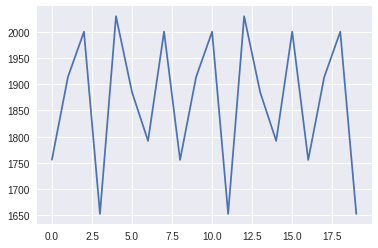

In [39]:
plt.plot(H.history['loss'])

In [36]:
frame = matr['Matr'][0]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
true_boxes = matr['Labels'][0]
targets = np.expand_dims(true_boxes,0)
y_true = preprocess_true_boxes(targets)
true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
y_pred = model_test.predict([frame,true_boxes,y_true])
y_pred.shape

(1,)

In [54]:
# frame = np.zeros((1,512,128,40,1))`]
frame = matr['Matr'][0]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
true_boxes = matr['Labels'][0]
targets = np.expand_dims(true_boxes,0)
y_true = preprocess_true_boxes(targets)
print(y_true.shape)
true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
true_loss = tf.to_float(1)
H = model_test.fit(x = [frame,true_boxes,y_true],y = true_boxes, epochs = 100)

(1, 16, 8, 5, 6, 10)
Epoch 1/100
1/1 [==============================] - 1s 788ms/step - loss: 2118.2422
Epoch 2/100
1/1 [==============================] - 1s 693ms/step - loss: 2117.6111
Epoch 3/100
1/1 [==============================] - 1s 706ms/step - loss: 2117.0564
Epoch 4/100
1/1 [==============================] - 1s 682ms/step - loss: 2116.8035
Epoch 5/100


KeyboardInterrupt: 

In [109]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax,zmin = 0, zmax = 80, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.zmin = zmin
        self.zmax = zmax
        self.c       = c
        
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]     
        return self.score  
    

def _sigmoid(x):
    return 1/(1 + np.exp(-x))

def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis, keepdims=True)

def decode_netout(netout,  obj_thresh = 0.7, anchors=  anchors_list,):
#     netout = np.random.uniform(size = (1, 16, 8, 5, 6, 10))
#     netout = preprocess_true_boxes(1,2,3,5)
#     obj_thresh = 0.7
    input_shape = (16,8,5)
    original_input_shape = (512,128,40)
    
    grid_h, grid_w,grid_d = netout.shape[1:4]
    num_boxes = len(anchors)
    netout = netout.reshape((grid_h, grid_w, grid_d,num_boxes, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for row in range(grid_h):
        for col in range(grid_w):
            for dep in range(grid_d):
                for b in range(num_boxes):
                    objectness = netout[row, col,dep, b, 4]
                    if(objectness <= obj_thresh): continue
                    x, y, w, h = netout[row,col,dep,b,:4]
                    x = (col*(original_input_shape[0]/input_shape[0]) + x) 
                    y = (row*(original_input_shape[1]/input_shape[1]) + y)
                    w = anchors[b][0] * np.exp(w) 
                    h = anchors[b][1] * np.exp(h)   
                    classes = netout[row,col,dep,b,5:]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
                    boxes.append(box)

    return boxes

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h, new_d = net_w, net_h , net_d
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

        
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


def bbox_iou_norm_3d(box1,box2):
    box_intersect = Box()
    box_intersect.xmin = max(box1.xmin,box2.xmin)
    box_intersect.ymin = max(box1.ymin,box2.ymin)
    box_intersect.zmin = max(box1.zmin,box2.zmin)
    box_intersect.xmax = min(box1.xmax,box2.xmax)
    box_intersect.ymax = min(box1.ymax,box2.ymax)
    box_intersect.zmax = min(box1.zmax,box2.zmax)
    
    if box_intersect.xmin > box_intersect.xmax or box_intersect.ymin > box_intersect.ymax or box_intersect.zmin > box_intersect.zmax:
        intersect_vol = 0
    else:
        intersect_vol = box_intersect.get_vol()
    
    union_vol = box1.get_vol() + box2.get_vol() - intersect_vol 
    
    return intersect_vol/union_vol

def do_nms_exp(boxes, nms_thresh):
    if len(boxes) ==  0:
        return
    sorted_indices = np.argsort([-box[0] for box in boxes])
    for i in range(len(sorted_indices)):
        index_i = sorted_indices[i]
        for j in range(i+1, len(sorted_indices)):
            index_j = sorted_indices[j]
            if bbox_iou_exp(boxes[index_i], boxes[index_j]) >= nms_thresh:
                boxes[index_j] = [0,0,0,0]
    return boxes
                
def bbox_iou_exp(box1, box2):
    intersect_w = _interval_overlap([box1[0] - box1[2] , box1[0]+ box1[2] ], [box2[0] - box2[2] , box2[0]+ box2[2]])
    intersect_h = _interval_overlap([box1[1] - box1[3] , box1[1]+ box1[3] ], [box2[1] - box2[3] , box2[1]+ box2[3]])
    intersect = intersect_w * intersect_h
    w1, h1 = box1[2], box1[3]
    w2, h2 = box2[2], box2[3]
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


In [475]:
print(len(boxes))
print(len(do_nms_exp(boxes, 0.2)))

13
13


In [476]:
boxes

[[158.69200325012207,
  69.62711334228516,
  23.750545978546143,
  19.71832513809204],
 [75.1298131942749, 99.35404896736145, 19.92430865764618, 9.389273822307587],
 [75.15455436706543, 104.05915355682373, 14.31962251663208, 9.411953091621399],
 [73.73608207702637, 101.26533365249634, 13.126304149627686, 8.30930769443512],
 [77.35872745513916,
  100.17855072021484,
  13.813210725784302,
  6.353226900100708],
 [73.94322681427002, 100.37355995178223, 9.723247289657593, 7.615216374397278],
 [76.9511833190918, 100.0672779083252, 9.982660412788391, 9.443621635437012],
 [165.63437795639038,
  197.10731744766235,
  21.576109528541565,
  29.97773051261902],
 [165.47846126556396,
  199.8426423072815,
  14.72717970609665,
  28.584139347076416],
 [164.93076753616333, 198.4712781906128, 12.40986943244934, 24.44025993347168],
 [166.70305252075195,
  197.684720993042,
  13.530881404876709,
  16.857030391693115],
 [0, 0, 0, 0],
 [166.47885417938232,
  196.8912501335144,
  9.304392337799072,
  34.2718

In [ ]:
# код для чекания битых кадров

pathname = os.path.abspath('data')
for file in glob.glob(pathname+'/*.mat'):
    matr = scipy.io.loadmat(file)
    for num_frame in range(len(matr['Labels'])):
        Labels = np.array(matr["Labels"][num_frame])
        Labels = Labels/2
        object_mask = Labels[:,0]
        if object_mask.shape[0] != 0:
            true_boxes = Labels[:,:]
            targets = np.expand_dims(Labels,0)
            frame = matr["Matr"][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
            y_true = preprocess_true_boxes(targets)
            print(file, num_frame,model.evaluate([frame,targets], y_true ))